# BEAT THE HEAT

##### IMPORTANTE: the direct prediction is a growth rate. There is a function to return the absolute value with the GVA prediction

#### LOAD DATA AND IMPORT LIBRARIES

In [1]:
#!pip install folium
#!pip install seaborn

import boto3
import pandas as pd
import numpy as np

from sagemaker import get_execution_role
import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta as td
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns


import matplotlib.pyplot as plt

import boto3

import fsspec
import folium
import geopandas as gpd
from sagemaker import get_execution_role


from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None) 

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


#### Reading the files with economic data and selecting the relevant variables

In [2]:
role = get_execution_role()
path = 's3://ecb-hackathon-data-group04-x19s00/economic_data_full/dataset_nuts3_2002-2018.csv'
df_aux = pd.read_csv(path)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
path2 = 's3://ecb-hackathon-data-group04-x19s00/economic_data_full/dataset_nuts3_2019-2021.csv'

tmp = pd.read_csv(path2)

In [4]:
#Unite data from 2002-2018 with data from 2019-onwards

df = pd.concat([df_aux, tmp], axis = 0)

In [5]:
df.count()

year        580049
geo         580049
variable    580049
sector      521579
unit        580049
value       578233
namefile    580049
dtype: int64

In [6]:
pd.Series({c: df[c].unique() for c in df})

year        [2013, 2014, 2015, 2016, 2017, 2018, 2002, 200...
geo         [AT111, AT112, AT113, AT121, AT122, AT123, AT1...
variable    [area, gdp, gross value added, employment, pop...
sector      [nan, A, B-E, C, F, G-I, G-J, J, K, K-N, L, M_...
unit                                      [KM2, MIO_EUR, THS]
value       [701.0, 1792.0, 1471.0, 3356.0, 3368.0, 1230.0...
namefile    [area.xlsx, gdp.xlsx, gva.xlsx, empl.xlsx, pop...
dtype: object

In [7]:
len(set(df["geo"].to_list()))

1364

In [8]:
set(df["namefile"])

{'area.xlsx', 'empl.xlsx', 'gdp.xlsx', 'gva.xlsx', 'pop.xlsx'}

#### DATA FOR ECONOMIC MODELS

We will use %change to reduce the influence of dimensions on the model.

#### Filling the data

We found null values within the dataset.The strategy we will apply for filling the data will be different for economic and climate data. 
For economic data, it seemed appropriate to use interpolated average grouped by NUTS_ID. However, we took into consideration the years that delimet the dataset.
For 2002 and 2003, we opted by backward filling (always grouped by NUTS_ID)
For 2020 onwards, we opted by forward filling (always grouped by NUTS_ID). Data in the middle will be filled with interpolate average.

In [9]:
def fill_economic_data(df_aux, col):
    
    
    df_aux["rel_years"] = df_aux['year'].isin([2002, 2003, 2004, 2020, 2021, 2022])
    aux_col = col+"_aux"
    df_aux[aux_col] = df_aux[col]
    df_aux[aux_col]= df_aux.groupby(["NUTS_ID"])[aux_col].bfill()
    
    df_aux[aux_col]= df_aux.groupby(["NUTS_ID"])[aux_col].ffill()
    
    df_aux[col] = np.where(df_aux["rel_years"] == True, df_aux[aux_col], df_aux[col])
    
    df_aux[col] = df_aux[col].interpolate()
    del df_aux[aux_col]
    del df_aux["rel_years"]
    return df_aux

##### Treating Extra Regio NUTS 3

In [10]:
#We aim at computing growth rates. We noticed there are null values within the dataset, which appear for regions ending in ZZZ (Extra-Regio NUTS 3).
#This regions will be excluded from the dataset
df = df.loc[df["geo"].str.contains("ZZZ") == False]

#####  Data on employment

We will be collecting on empolyment for A and C sectors. We will compute growth rates

In [11]:
dfEmp_prep = df.loc[df["namefile"] == 'empl.xlsx'].copy()

# Select only the needed sectors
dfEmp_prep = dfEmp_prep.loc[(dfEmp_prep["sector"] == "A")|(dfEmp_prep["sector"] == "C")]
dfEmp_prep.rename(columns = {"geo":"NUTS_ID"}, inplace = True)

# Segregate into columns the information for each sector
dfEmp_prep = pd.pivot_table(dfEmp_prep, values = 'value', index=['NUTS_ID','year'], columns = 'sector').reset_index()
dfEmp_prep.rename(columns = {"A": "A_emp", "C": "C_emp",}, inplace = True)

#Lagging employment and computing growth rate
for col in ["A_emp","C_emp"]:
    dfEmp_prep = fill_economic_data(dfEmp_prep, col)
    dfEmp_prep[col+'_lag'] = dfEmp_prep.groupby(['NUTS_ID'])[col].shift(1)
    
    #Creating a lagged variable gives us a null value for the first year, reason why, we will proceed with backward filling
    dfEmp_prep[col+'_lag']= dfEmp_prep.groupby(["NUTS_ID"])[col+'_lag'].bfill()
    dfEmp_prep[col+'_perc'] =  (dfEmp_prep[col]- dfEmp_prep[col+'_lag'])/ dfEmp_prep[col+'_lag']
    
    #We will also need to account for null values in the economic variable
    #If there is no change, growth rate will be zero. If the lagged variable is zero, growth rate will be 1.
    dfEmp_prep[col+'_perc']= np.where((dfEmp_prep[col+'_lag'] == 0) & (dfEmp_prep[col] != 0), 1, \
                        np.where((dfEmp_prep[col+'_lag'] == 0) & (dfEmp_prep[col] ==0), 0, dfEmp_prep[col+'_perc']))
    
    

#Correcting the growth rate of the first year, make it backward fill
dfEmp_prep["year"] = dfEmp_prep["year"].astype(int)
gva_aux = dfEmp_prep[["NUTS_ID", "year"]].copy()
gva_aux.rename(columns={'year': 'minimum_year'}, inplace=True)
gva_aux = gva_aux.groupby("NUTS_ID")["minimum_year"].aggregate(['min']).reset_index()
dfEmp = dfEmp_prep.merge(gva_aux, on = "NUTS_ID", how = 'outer')

for col in dfEmp.columns:
    if "_perc" in col:
        dfEmp[col] = np.where(dfEmp["year"] ==dfEmp["min"], np.nan, dfEmp[col])
        dfEmp[col]= dfEmp.groupby(["NUTS_ID"])[col].bfill()


##### Data on Area

We find some missing values that we will be backward and forward filling, if needed (always grouped by NUTS_ID)

In [12]:
dfarea = df.loc[df["namefile"] == 'area.xlsx'].copy()
dfarea.rename(columns = {"geo":"NUTS_ID", "value": "area"}, inplace = True)
dfarea.drop(columns = ['variable', 'sector', 'unit',  'namefile'], inplace = True)

#Filling the data
dfarea["area"]= dfarea.groupby(["NUTS_ID"])["area"].bfill()
dfarea["area"]= dfarea.groupby(["NUTS_ID"])["area"].ffill()


##### Data on GVA

We will need data for agriculture, manufacturing, energy and transportation.
We will use a proxy for energy by subtracting manufacturing to [B-E]

In [13]:
dfGva_prep = df.loc[df["namefile"] == 'gva.xlsx'].copy()

#Select only the needed sectors
dfGva_prep = dfGva_prep.loc[(dfGva_prep["sector"] == "A")|(dfGva_prep["sector"] == "C") | (dfGva_prep["sector"] == "G-J") |  (dfGva_prep["sector"] == "B-E")]
dfGva_prep.rename(columns = {"geo":"NUTS_ID"}, inplace = True)
dfGva_prep = pd.pivot_table(dfGva_prep, values = 'value', index=['NUTS_ID','year'], columns = 'sector').reset_index()

# Segregate into columns the information for each sector
dfGva_prep.rename(columns = {"A": "A_Gva", "C": "C_Gva", "G-J": "G-J_Gva", "B-E": "B-E_Gva"}, inplace = True)

# Some missing data appear, therefore we will use the previously defined function 
for col in ["A_Gva","C_Gva", "G-J_Gva", "B-E_Gva"]:
    dfGva_prep = fill_economic_data(dfGva_prep, col)

#Computing the proxy for energy 
dfGva_prep["Gva_Energ"] = dfGva_prep["B-E_Gva"]- dfGva_prep["C_Gva"]


for col in ["A_Gva","C_Gva", "G-J_Gva", "B-E_Gva", "Gva_Energ"]:
    
    #Obtain lagged variables and fill empty data 
    dfGva_prep[col+'_lag'] = dfGva_prep.groupby(['NUTS_ID'])[col].shift(1)
    #Creating a lagged variable gives us a null value for the first year, reason why, we will proceed with backward filling
    dfGva_prep[col+'_lag']= dfGva_prep.groupby(["NUTS_ID"])[col+'_lag'].bfill()
    
    #Computing growth rates
    dfGva_prep[col+'_perc'] =  (dfGva_prep[col]- dfGva_prep[col+'_lag'])/ dfGva_prep[col+'_lag']
    
    #We will also need to account for null values in the economic variable
    #If there is no change, growth rate will be zero. If the lagged variable is zero, growth rate will be 1. First year of the dataset will be taken care of later
    dfGva_prep[col+'_perc']= np.where((dfGva_prep[col+'_lag'] == 0) & (dfGva_prep[col] != 0), 1, \
                        np.where((dfGva_prep[col+'_lag'] == 0) & (dfGva_prep[col] ==0), 0, dfGva_prep[col+'_perc']))
    
    
    #Correcting the growth rate of the first year, make it backward fill
    dfGva_prep["year"] = dfGva_prep["year"].astype(int)
    gva_aux = dfGva_prep[["NUTS_ID", "year"]].copy()
    gva_aux.rename(columns={'year': 'minimum_year'}, inplace=True)
    gva_aux = gva_aux.groupby("NUTS_ID")["minimum_year"].aggregate(['min']).reset_index()
    dfGva = dfGva_prep.merge(gva_aux, on = "NUTS_ID", how = 'outer')
    
    for col in dfGva.columns:
        if "_perc" in col:
            dfGva[col] = np.where(dfGva["year"] ==dfGva["min"], np.nan, dfGva[col])
            dfGva[col]= dfGva.groupby(["NUTS_ID"])[col].bfill()
    
    

dfGva_Area = dfGva.merge(dfarea, on = ["NUTS_ID", "year"], how = 'outer')

dfGva_Area.sort_values(by = ["NUTS_ID", "year"], inplace = True)


In [14]:
dfGva.columns

Index(['NUTS_ID', 'year', 'A_Gva', 'B-E_Gva', 'C_Gva', 'G-J_Gva', 'Gva_Energ',
       'A_Gva_lag', 'A_Gva_perc', 'C_Gva_lag', 'C_Gva_perc', 'G-J_Gva_lag',
       'G-J_Gva_perc', 'B-E_Gva_lag', 'B-E_Gva_perc', 'Gva_Energ_lag',
       'Gva_Energ_perc', 'min'],
      dtype='object')

In [15]:
dfGva.shape[0]

22270

In [16]:
dfEmp.loc[dfEmp["NUTS_ID"] == "AT112"]

NUTS_ID  year  A_emp  C_emp  A_emp_lag  A_emp_perc  C_emp_lag  C_emp_perc  \
19   AT112  2002    6.0    7.0        6.0   -0.016667        7.0    0.071429   
20   AT112  2003    5.9    7.5        6.0   -0.016667        7.0    0.071429   
21   AT112  2004    5.6    7.3        5.9   -0.050847        7.5   -0.026667   
22   AT112  2005    5.4    6.8        5.6   -0.035714        7.3   -0.068493   
23   AT112  2006    5.2    7.0        5.4   -0.037037        6.8    0.029412   
24   AT112  2007    5.2    7.4        5.2    0.000000        7.0    0.057143   
25   AT112  2008    5.1    7.0        5.2   -0.019231        7.4   -0.054054   
26   AT112  2009    4.9    6.8        5.1   -0.039216        7.0   -0.028571   
27   AT112  2010    4.7    6.9        4.9   -0.040816        6.8    0.014706   
28   AT112  2011    4.6    7.1        4.7   -0.021277        6.9    0.028986   
29   AT112  2012    4.4    7.3        4.6   -0.043478        7.1    0.028169   
30   AT112  2013    4.4    7.5        4.4    0.000000        7.3    0.027397   
31   AT112  2014    4.7    7.8        4.4    0.068182        7.5    0.040000   
32   AT112  2015    4.7    7.7        4.7    0.000000        7.8   -0.012821   
33   AT112  2016    4.6    7.5        4.7   -0.021277        7.7   -0.025974   
34   AT112  2017    4.6    8.0        4.6    0.000000        7.5    0.066667   
35   AT112  2018    4.4    8.0        4.6   -0.043478        8.0    0.000000   
36   AT112  2019    4.3    7.9        4.4   -0.022727        8.0   -0.012500   
37   AT112  2020    4.4    7.7        4.3    0.023256        7.9   -0.025316   

     min  
19  2002  
20  2002  
21  2002  
22  2002  
23  2002  
24  2002  
25  2002  
26  2002  
27  2002  
28  2002  
29  2002  
30  2002  
31  2002  
32  2002  
33  2002  
34  2002  
35  2002  
36  2002  
37  2002

In [17]:
dfGva.to_csv("datafolder/economic_24_11.csv")

In [18]:
dfGva.describe()

year         A_Gva       B-E_Gva         C_Gva       G-J_Gva  \
count  22270.000000  22270.000000  22270.000000  22270.000000  22270.000000   
mean    2011.120162    166.693767   1764.608143   1479.224890   2088.751824   
std        5.542687    201.962723   2480.484820   2159.149967   4488.562425   
min     2002.000000   -172.050000   -129.200000   -372.900000     25.000000   
25%     2006.000000     42.000000    486.152500    378.602500    429.437500   
50%     2011.000000     97.000000   1023.700000    832.200000    881.255000   
75%     2016.000000    221.200000   2111.240000   1785.415000   1917.907500   
max     2021.000000   2567.700000  69617.290000  68437.210000  71999.800000   

          Gva_Energ     A_Gva_lag    A_Gva_perc     C_Gva_lag    C_Gva_perc  \
count  22270.000000  22270.000000  22270.000000  22270.000000  22270.000000   
mean     285.383254    164.525033      0.029352   1453.318002      0.027538   
std      510.744590    199.254122      0.346351   2090.355329      0.132502   
min     -144.390000   -172.050000     -1.916427   -372.900000     -3.157147   
25%       61.977500     41.402500     -0.074645    370.120000     -0.029978   
50%      141.240000     95.605000      0.011340    813.640000      0.023125   
75%      301.417500    217.797500      0.107813   1754.390000      0.077078   
max    10158.000000   2516.400000     35.432432  54303.170000      7.427419   

        G-J_Gva_lag  G-J_Gva_perc   B-E_Gva_lag  B-E_Gva_perc  Gva_Energ_lag  \
count  22270.000000  22270.000000  22270.000000  22270.000000   22270.000000   
mean    2043.087981      0.027407   1730.709679      0.028998     277.391678   
std     4387.373945      0.079605   2409.420124      0.126786     498.261191   
min       25.000000     -0.679192   -129.200000     -9.041796    -144.390000   
25%      421.120000     -0.006149    473.660000     -0.024784      59.400000   
50%      861.595000      0.026778    999.180000      0.024570     136.995000   
75%     1877.937500      0.057975   2070.847500      0.074907     293.490000   
max    71999.800000      0.977917  54579.840000      2.427097   10158.000000   

       Gva_Energ_perc           min  
count    22270.000000  22270.000000  
mean         0.051106   2002.033947  
std          1.132109      0.181097  
min       -139.714286   2002.000000  
25%         -0.038938   2002.000000  
50%          0.032273   2002.000000  
75%          0.111323   2002.000000  
max         52.950673   2003.000000

##### Data on population

In [19]:
dfpop = df.loc[df["namefile"] == 'pop.xlsx'].copy()
dfpop.rename(columns = {"geo":"NUTS_ID", "value": "pop"}, inplace = True)
dfpop.drop(columns = ['variable', 'sector', 'unit',  'namefile'], inplace = True)
col = "pop"

dfpop[col+'_lag'] = dfpop.groupby(['NUTS_ID'])[col].shift(1)
#Creating a lagged variable gives us a null value for the first year, reason why, we will proceed with backward filling
dfpop[col+'_lag']= dfpop.groupby(["NUTS_ID"])[col+'_lag'].bfill()

dfpop[col+'_perc'] =  (dfpop[col]- dfpop[col+'_lag'])/ dfpop[col+'_lag']

#We will also need to account for null values in the economic variable
#If there is no change, growth rate will be zero. If the lagged variable is zero, growth rate will be 1.
dfpop[col+'_perc']= np.where((dfpop[col+'_lag'] == 0) & (dfpop[col] != 0), 1, \
                    np.where((dfpop[col+'_lag'] == 0) & (dfpop[col] ==0), 0, dfpop[col+'_perc']))


In [20]:
dfEmp.dtypes

NUTS_ID        object
year            int64
A_emp         float64
C_emp         float64
A_emp_lag     float64
A_emp_perc    float64
C_emp_lag     float64
C_emp_perc    float64
min             int64
dtype: object

##### Gathering Economic Data

In [21]:
final_econ_data = dfGva_Area.merge(dfpop, on = ["NUTS_ID", "year"], how = 'outer')
final_econ_data = final_econ_data.merge(dfEmp, on = ["NUTS_ID", "year"], how = 'outer')

##### Filling empty data

We will use previously created function

In [22]:
for col in ['A_Gva', 'B-E_Gva', 'C_Gva', 'G-J_Gva', 'Gva_Energ',
       'A_Gva_lag', 'A_Gva_perc', 'C_Gva_lag', 'C_Gva_perc', 'G-J_Gva_lag',
       'G-J_Gva_perc', 'B-E_Gva_lag', 'B-E_Gva_perc', 'Gva_Energ_lag',
       'Gva_Energ_perc', 'area', 'pop', 'pop_lag', 'pop_perc', 'A_emp',
       'C_emp', 'A_emp_lag', 'A_emp_perc', 'C_emp_lag', 'C_emp_perc']:

    final_econ_data = fill_economic_data(final_econ_data, col)
    
    

del final_econ_data['min_x']
del final_econ_data['min_y']
final_econ_data.sort_values(by= ["NUTS_ID", "year"], inplace = True)

In [23]:
final_econ_data

NUTS_ID  year   A_Gva  B-E_Gva    C_Gva  G-J_Gva  Gva_Energ  A_Gva_lag  \
0       AT111  2002   37.00   117.00    92.00   106.00      25.00      37.00   
1       AT111  2003   55.00   129.00    95.00   117.00      34.00      37.00   
2       AT111  2004   45.00   119.00    92.00   116.00      27.00      55.00   
3       AT111  2005   34.00   136.00   110.00   113.00      26.00      45.00   
4       AT111  2006   37.00   136.00   111.00   123.00      25.00      34.00   
...       ...   ...     ...      ...      ...      ...        ...        ...   
26237   SK042  2018  235.71  2597.97  2486.22  2458.81     111.75     216.82   
26238   SK042  2019  195.54  2651.68  2546.43  2642.94     105.25     235.71   
26239   SK042  2020  183.78  2463.48  2337.87  2663.64     125.61     195.54   
26240   SK042  2021  208.22  2958.89  2835.63  2861.08     123.26     183.78   
26241   SK042  2022  208.22  2958.89  2835.63  2861.08     123.26     183.78   

       A_Gva_perc  C_Gva_lag  C_Gva_perc  G-J_Gva_lag  G-J_Gva_perc  \
0        0.486486      92.00    0.032609       106.00      0.103774   
1        0.486486      92.00    0.032609       106.00      0.103774   
2       -0.181818      95.00   -0.031579       117.00     -0.008547   
3       -0.244444      92.00    0.195652       116.00     -0.025862   
4        0.088235     110.00    0.009091       113.00      0.088496   
...           ...        ...         ...          ...           ...   
26237    0.087123    2258.92    0.100623      2444.02      0.006052   
26238   -0.170421    2486.22    0.024217      2458.81      0.074886   
26239   -0.060141    2546.43   -0.081903      2642.94      0.007832   
26240    0.132985    2337.87    0.212912      2663.64      0.074124   
26241    0.132985    2337.87    0.212912      2663.64      0.074124   

       B-E_Gva_lag  B-E_Gva_perc  Gva_Energ_lag  Gva_Energ_perc    area  \
0           117.00      0.102564          25.00        0.360000   701.0   
1           117.00      0.102564          25.00        0.360000   701.0   
2           129.00     -0.077519          34.00       -0.205882   701.0   
3           119.00      0.142857          27.00       -0.037037   701.0   
4           136.00      0.000000          26.00       -0.038462   701.0   
...            ...           ...            ...             ...     ...   
26237      2350.20      0.105425          91.28        0.224255  6754.0   
26238      2597.97      0.020674         111.75       -0.058166  6754.0   
26239      2651.68     -0.070974         105.25        0.193444  6754.0   
26240      2463.48      0.201102         125.61       -0.018709  6754.0   
26241      2463.48      0.201102         125.61       -0.018709  6754.0   

          pop  pop_lag  pop_perc  A_emp  C_emp  A_emp_lag  A_emp_perc  \
0       37.73    37.73  0.000000   1.60   2.20       1.60    0.000000   
1       37.65    37.73 -0.002120   1.60   2.20       1.60    0.000000   
2       37.58    37.65 -0.001859   1.50   2.30       1.60   -0.062500   
3       37.45    37.58 -0.003459   1.40   2.20       1.50   -0.066667   
4       37.45    37.45  0.000000   1.30   2.30       1.40   -0.071429   
...       ...      ...       ...    ...    ...        ...         ...   
26237  799.60   798.50  0.001378   8.86  56.11       8.77    0.010262   
26238  800.70   799.60  0.001376   9.14  56.14       8.86    0.031603   
26239  801.77   800.70  0.001336   8.62  53.75       9.14   -0.056893   
26240  781.05   801.77 -0.025843   8.62  53.75       9.14   -0.056893   
26241  781.05   801.77 -0.025843   8.62  53.75       9.14   -0.056893   

       C_emp_lag  C_emp_perc  
0           2.20    0.000000  
1           2.20    0.000000  
2           2.20    0.045455  
3           2.30   -0.043478  
4           2.20    0.045455  
...          ...         ...  
26237      56.88   -0.013537  
26238      56.11    0.000535  
26239      56.14   -0.042572  
26240      56.14   -0.042572  
26241      56.14   -0.042572  

[26326 rows x 27 columns]

In [24]:
agr = final_econ_data[[ "NUTS_ID", "year",'pop_perc', 'A_emp_perc', "A_Gva_perc"]]

In [25]:
ind = final_econ_data[['NUTS_ID', 'year','G-J_Gva_perc', 
       'Gva_Energ_perc',  "A_Gva_perc",  'pop_perc',
       'C_emp_perc', 'C_Gva_perc']]

In [26]:
ind

NUTS_ID  year  G-J_Gva_perc  Gva_Energ_perc  A_Gva_perc  pop_perc  \
0       AT111  2002      0.103774        0.360000    0.486486  0.000000   
1       AT111  2003      0.103774        0.360000    0.486486 -0.002120   
2       AT111  2004     -0.008547       -0.205882   -0.181818 -0.001859   
3       AT111  2005     -0.025862       -0.037037   -0.244444 -0.003459   
4       AT111  2006      0.088496       -0.038462    0.088235  0.000000   
...       ...   ...           ...             ...         ...       ...   
26237   SK042  2018      0.006052        0.224255    0.087123  0.001378   
26238   SK042  2019      0.074886       -0.058166   -0.170421  0.001376   
26239   SK042  2020      0.007832        0.193444   -0.060141  0.001336   
26240   SK042  2021      0.074124       -0.018709    0.132985 -0.025843   
26241   SK042  2022      0.074124       -0.018709    0.132985 -0.025843   

       C_emp_perc  C_Gva_perc  
0        0.000000    0.032609  
1        0.000000    0.032609  
2        0.045455   -0.031579  
3       -0.043478    0.195652  
4        0.045455    0.009091  
...           ...         ...  
26237   -0.013537    0.100623  
26238    0.000535    0.024217  
26239   -0.042572   -0.081903  
26240   -0.042572    0.212912  
26241   -0.042572    0.212912  

[26326 rows x 8 columns]

In [27]:
agr.describe()

agr.to_csv("datafolder/econ_predictive_agr_2411.csv")
ind.to_csv("datafolder/econ_Predictive_man_2411.csv")

In [28]:
agr.shape[0]

26326

#### Visualization Gross Value Added as % change

For SK042 and agriculture

asdasd
['year', 'geo', 'variable', 'sector', 'unit', 'value', 'namefile']
47846     0.000000
47847     3.056499
47848     4.583583
47849   -13.348611
47850    79.206612
47851    41.975650
47852    25.329695
47853   -27.171885
47854   -19.537367
47855    24.732419
47856    -0.184384
47857    19.019538
47858    36.132999
47859   -12.006139
47860    -3.054767
47861    11.452658
47862     8.712296
10620   -17.042128
10621    -6.014115
10622    13.298509
Name: prc, dtype: float64
asdasd


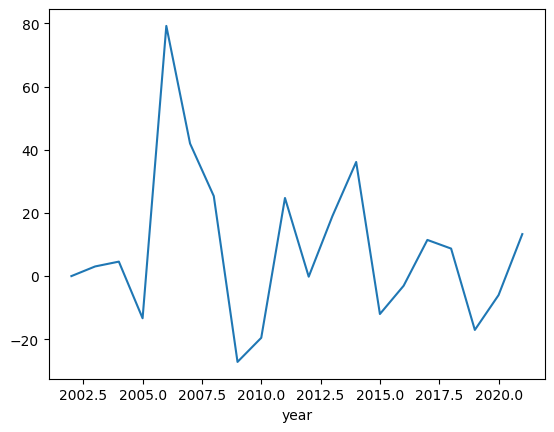

In [29]:


dfVAde = df.loc[df["namefile"] == 'gva.xlsx']
dfVAde = dfVAde[dfVAde['geo'] == 'SK042']
dfVAde = dfVAde[dfVAde['sector'] == 'A']
print('asdasd')
dfplot = dfVAde[dfVAde['variable'] == 'gross value added']
print(dfplot.columns.tolist())

dfplot['prc'] = dfplot.value.pct_change() * 100
dfplot.iat[0,7] = 0
print(dfplot['prc'])

fig,ax = plt.subplots()

for name in ['prc']:
    ax.plot(dfplot.year,dfplot[name],label=name)

ax.set_xlabel("year")
print('asdasd')

### Load climate data

Climate data is presented to us on a daily basis. Therefore we need to summarize data in order to fit yearly data.

#### 1. SPI : precipitation anomalies (for an accumulation period of interest)
For any given region, increasingly severe rainfall deficits (i.e., meteorological droughts) are indicated as SPI decreases below 1.0, while increasingly severe excess rainfall are indicated as SPI increases above 1.0.
The suffix is the accumulation period. 
Thus, SPI-01 and SPI-03, for example, refer to accumulation periods of one and three months, respectively.  

Below is the classification of the severity of the drought

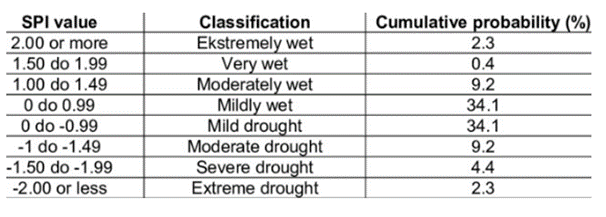

#### Create spi_01 by aggregating all datasets

Several indicators will be created. Values of spi will be categorized and the occurrence of each category will be counted. Quantiles, min, max, mean and median will also be computed

In [30]:
path = 's3://ecb-hackathon-data-group04-x19s00/climate_data_full/spi/spa01_NUTS3_MEDIAN_'
years = range(2001,2023)

In [31]:
spi_01 = []
for year in years:
    p = path+str(year)+'.csv'
    tmp = pd.read_csv(p, index_col=None, header=0)
    spi_01.append(tmp)

spi_01 = pd.concat(spi_01, axis=0, ignore_index=True)

In [32]:
spi_01.rename(columns={' MEDIAN                                                      ': 'spi_01'}, inplace=True)

In [33]:
#Values of spi will be categorized and the occurrence of each category will be counted
spi_01["spi_01_class"] = np.where(spi_01["spi_01"] <= -2, "spi_01_Extremely drought", np.where(spi_01["spi_01"] <= -1.5, "spi_01_Severe drought", \
                                  np.where(spi_01["spi_01"] <= -1, "spi_01_Moderate drought",  np.where(spi_01["spi_01"] <= 0, "spi_01_Mild drought", \
                                        np.where(spi_01["spi_01"] <= 0.99, "spi_01_Mild wet", np.where(spi_01["spi_01"] <= 1.5, "spi_01_Moderately wet", \
                                          np.where(spi_01["spi_01"] <= 2, "spi_01_Very wet", "spi_01_Extremely wet")))))))
spi_01[' TIMESTAMP'] = pd.to_datetime(spi_01[' TIMESTAMP'])
spi_01["month"] = spi_01[' TIMESTAMP'].dt.month
spi_01["year"] = spi_01[' TIMESTAMP'].dt.year





#### Variables not counted
spi_aux_not_lagged = spi_01.copy()
spi_aux_not_lagged = pd.pivot_table(spi_aux_not_lagged, values = 'spi_01', index=['NUTS_ID','year'], columns = 'spi_01_class').reset_index()




#### Number of ocorrences
spi_aux_count = spi_01.copy()
spi_aux_count = spi_aux_count.groupby(['year', 'NUTS_ID', 'spi_01_class'])['spi_01'].aggregate(['count']).reset_index()
spi_aux_count.rename(columns = {'count':'spi_01'}, inplace = True)
spi_aux_count = pd.pivot_table(spi_aux_count, values = 'spi_01', index=['NUTS_ID','year'], columns = 'spi_01_class').reset_index()

for col in ['spi_01_Extremely drought', 'spi_01_Extremely wet',
       'spi_01_Mild drought', 'spi_01_Mild wet', 'spi_01_Moderate drought',
       'spi_01_Moderately wet', 'spi_01_Severe drought', 'spi_01_Very wet']:
    spi_aux_count.rename(columns = {col:"N_"+col}, inplace = True)
    spi_aux_count["N_"+col].fillna(0, inplace = True)
    

#### Several indicators
spi_not_lagged = spi_01.copy()

spi_not_lagged = spi_not_lagged.groupby(['year', 'NUTS_ID'])['spi_01'].aggregate(['max', 'min', 'mean', 'median']).reset_index()




##### Getting the quantiles

quantiles = spi_01.copy()
quantiles = quantiles.groupby(["NUTS_ID", "year"])["spi_01"].quantile([.1, .9]).reset_index()
quantiles.rename(columns = {"level_2": "quantile"}, inplace = True)
quantiles = pd.pivot_table(quantiles, values = 'spi_01', index=['NUTS_ID','year'], columns = 'quantile').reset_index()
quantiles.rename(columns = {0.1: "spi01_1st qtl", 0.9: "spi01_9th atl"}, inplace = True)



#spi_01_final = spi_not_lagged.merge(spi_aux_class, on = ['year', 'NUTS_ID'], how = 'outer')
spi_01_final = spi_not_lagged.merge(spi_aux_count, on = ['year', 'NUTS_ID'], how = 'outer')
#spi_01_final = spi_01_final.merge(lag1, on = ['year', 'NUTS_ID'], how = 'outer')
spi_01_final.rename(columns = {'max':"spi_01_max", 'min':"spi_01_min", 'median':"spi_01_median", 'mean':"spi_01_mean"}, inplace = True)
spi_01_final = spi_01_final.merge(quantiles, on = ['year', 'NUTS_ID'], how = 'outer')

In [34]:
#spi_01.loc[(spi_01["spi_01_class"] == "spi_01_Mild wet") & (spi_01["NUTS_ID"] == "AL011") &(spi_01["year"] == 2001)]

In [35]:
spi_01_final["year"].unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype=int32)

#### Create spi_03 by aggregating all datasets

Several indicators will be created. Values of spi will be categorized and the occurrence of each category will be counted. Quantiles, min, max, mean and median will also be computed. 

Additionally, values at the end of each quarter were computed. Given that values are cumulative, values for the 3rd, 6th, 9th, 12th months will be segregated into columns

In [36]:
path = 's3://ecb-hackathon-data-group04-x19s00/climate_data_full/spi/spa03_NUTS3_MEDIAN_'
spi_03 = []
for year in years:
    p = path+str(year)+'.csv'
    tmp = pd.read_csv(p, index_col=None, header=0)
    spi_03.append(tmp)

spi_03 = pd.concat(spi_03, axis=0, ignore_index=True)

In [37]:
spi_03.rename(columns={' MEDIAN                                                      ': 'spi_03'}, inplace=True)

In [38]:
# Aggregate the values into categories to count occurrences later
spi_03["SPI03_class"] = np.where(spi_03["spi_03"] <= -2, "SPI03_Extremely drought", np.where(spi_03["spi_03"] <= -1.5, "SPI03_Severe drought", \
                                  np.where(spi_03["spi_03"] <= -1, "SPI03_Moderate drought",  np.where(spi_03["spi_03"] <= 0, "SPI03_Mild drought", \
                                        np.where(spi_03["spi_03"] <= 0.99, "SPI03_Mild wet", np.where(spi_03["spi_03"] <= 1.5, "SPI03_Moderately wet", \
                                          np.where(spi_03["spi_03"] <= 2, "SPI03_Very wet", "SPI03_Extremely wet")))))))
spi_03[' TIMESTAMP'] = pd.to_datetime(spi_03[' TIMESTAMP'])
spi_03["month"] = spi_03[' TIMESTAMP'].dt.month
spi_03["year"] = spi_03[' TIMESTAMP'].dt.year




#### Variables not counted
spi_aux_not_lagged = spi_03.copy()
spi_aux_not_lagged = pd.pivot_table(spi_aux_not_lagged, values = 'spi_03', index=['NUTS_ID','year'], columns = 'SPI03_class').reset_index()




#### Number of ocorrences
spi_aux_count = spi_03.copy()
spi_aux_count = spi_aux_count.groupby(['year', 'NUTS_ID', 'SPI03_class'])['spi_03'].aggregate(['count']).reset_index()
spi_aux_count.rename(columns = {'count':'spi_03'}, inplace = True)
spi_aux_count = pd.pivot_table(spi_aux_count, values = 'spi_03', index=['NUTS_ID','year'], columns = 'SPI03_class').reset_index()

for col in ['SPI03_Extremely drought', 'SPI03_Extremely wet',
       'SPI03_Mild drought', 'SPI03_Mild wet', 'SPI03_Moderate drought',
       'SPI03_Moderately wet', 'SPI03_Severe drought', 'SPI03_Very wet']:
    spi_aux_count.rename(columns = {col:"N_"+col}, inplace = True)
    spi_aux_count["N_"+col].fillna(0, inplace = True)
    

#### Several indicators
spi_not_lagged = spi_03.copy()

spi_not_lagged = spi_not_lagged.groupby(['year', 'NUTS_ID'])['spi_03'].aggregate(['max', 'min', 'mean', 'median']).reset_index()
spi_not_lagged.rename(columns = {'max':"spi_03_max", 'min':"spi_03_min", 'median':"spi_03_median", 'mean':"spi_03_mean"}, inplace = True)


##### Getting the quantiles

quantiles = spi_03.copy()
quantiles = quantiles.groupby(["NUTS_ID", "year"])["spi_03"].quantile([.1, .9]).reset_index()
quantiles.rename(columns = {"level_2": "quantile"}, inplace = True)
quantiles = pd.pivot_table(quantiles, values = 'spi_03', index=['NUTS_ID','year'], columns = 'quantile').reset_index()
quantiles.rename(columns = {0.1: "spi03_1st qtl", 0.9: "spi03_9th atl"}, inplace = True)




### Additionally, values at the end of each quarter were computed. Given that values are cumulative, values for the 3rd, 6th, 9th, 12th months will be segregated into columns

spi_aux = spi_03.copy()
spi_aux = spi_aux.loc[(spi_aux["month"] == 3) | (spi_aux["month"] == 6) | (spi_aux["month"] == 9) |(spi_aux["month"] == 12)]

spi_aux = pd.pivot_table(spi_aux, values = 'spi_03', index=['NUTS_ID','year'], columns = 'month').reset_index()
spi_aux.rename(columns = {3: "SPI03_3month", 6: "SPI03_6month", 9: "SPI03_9month", 12: "SPI03_12month"}, inplace = True)




#spi12_final = spi_not_lagged.merge(spi_aux_class, on = ['year', 'NUTS_ID'], how = 'outer')
SPI03_final = spi_aux.merge(spi_aux_count, on = ['year', 'NUTS_ID'], how = 'outer')
SPI03_final.rename(columns = {'max':"spi_03_max", 'min':"spi_03_min", 'median':"spi_03_median", 'mean':"spi_03_mean"}, inplace = True)
SPI03_final = SPI03_final.merge(quantiles, on = ['year', 'NUTS_ID'], how = 'outer')
SPI03_final = SPI03_final.merge(spi_not_lagged, on = ['year', 'NUTS_ID'], how = 'outer')



In [39]:
SPI03_final

NUTS_ID  year  SPI03_3month  SPI03_6month  SPI03_9month  SPI03_12month  \
0       AL011  2001         0.020         0.446         0.531         -0.602   
1       AL011  2002        -1.740         0.263         2.367         -0.417   
2       AL011  2003        -0.001        -1.510        -0.935          1.001   
3       AL011  2004         1.459         1.301         0.327         -0.061   
4       AL011  2005         0.762        -0.468         0.457          1.152   
...       ...   ...           ...           ...           ...            ...   
33237   UKN0G  2018         0.600        -0.387        -0.574         -0.631   
33238   UKN0G  2019         0.004         0.414         1.241         -0.098   
33239   UKN0G  2020         1.584        -0.774         0.620          1.122   
33240   UKN0G  2021         0.910        -1.159        -0.457         -0.371   
33241   UKN0G  2022        -0.037         0.835        -0.767          1.136   

       N_SPI03_Extremely drought  N_SPI03_Extremely wet  N_SPI03_Mild drought  \
0                            0.0                    0.0                   7.0   
1                            0.0                    1.0                   5.0   
2                            1.0                    0.0                   3.0   
3                            0.0                    0.0                   3.0   
4                            0.0                    0.0                   6.0   
...                          ...                    ...                   ...   
33237                        0.0                    0.0                   7.0   
33238                        0.0                    0.0                   4.0   
33239                        1.0                    0.0                   2.0   
33240                        0.0                    0.0                   7.0   
33241                        0.0                    0.0                   5.0   

       N_SPI03_Mild wet  N_SPI03_Moderate drought  N_SPI03_Moderately wet  \
0                   5.0                       0.0                     0.0   
1                   3.0                       0.0                     1.0   
2                   2.0                       1.0                     2.0   
3                   4.0                       0.0                     4.0   
4                   5.0                       0.0                     1.0   
...                 ...                       ...                     ...   
33237               3.0                       2.0                     0.0   
33238               3.0                       0.0                     5.0   
33239               4.0                       0.0                     4.0   
33240               4.0                       1.0                     0.0   
33241               3.0                       0.0                     3.0   

       N_SPI03_Severe drought  N_SPI03_Very wet  spi03_1st qtl  spi03_9th atl  \
0                         0.0               0.0        -0.5929         0.4389   
1                         1.0               1.0        -0.9296         1.8574   
2                         2.0               1.0        -1.9150         1.3052   
3                         0.0               1.0        -0.0628         1.4432   
4                         0.0               0.0        -0.2857         0.7908   
...                       ...               ...            ...            ...   
33237                     0.0               0.0        -1.0141         0.2910   
33238                     0.0               0.0        -0.6650         1.3004   
33239                     0.0               1.0        -0.7352         1.4795   
33240                     0.0               0.0        -0.7806         0.9059   
33241                     0.0               1.0        -0.8696         1.1330   

       spi_03_max  spi_03_min  spi_03_mean  spi_03_median  
0           0.531      -0.602    -0.090917        -0.1795  
1           2.367      -1.740     0.163917        -0.0

#### Create spi_06 by aggregating all datasets

Several indicators will be created. Values of spi will be categorized and the occurrence of each category will be counted. Quantiles, min, max, mean and median will also be computed. 

Additionally, values for each semester were computed at the end of the semester. Given that values are cumulative, values for the 6th, 12th months will be segregated into columns

In [40]:
path = 's3://ecb-hackathon-data-group04-x19s00/climate_data_full/spi/spa06_NUTS3_MEDIAN_'
spi_06 = []
for year in years:
    p = path+str(year)+'.csv'
    tmp = pd.read_csv(p, index_col=None, header=0)
    spi_06.append(tmp)

spi_06 = pd.concat(spi_06, axis=0, ignore_index=True)

In [41]:
spi_06.rename(columns={' MEDIAN                                                      ': 'spi_06'}, inplace=True)

In [42]:
spi_06["Spi06_class"] = np.where(spi_06["spi_06"] <= -2, "SPI06_Extremely drought", np.where(spi_06["spi_06"] <= -1.5, "SPI06_Severe drought", \
                                  np.where(spi_06["spi_06"] <= -1, "SPI06_Moderate drought",  np.where(spi_06["spi_06"] <= 0, "SPI06_Mild drought", \
                                        np.where(spi_06["spi_06"] <= 0.99, "SPI06_Mild wet", np.where(spi_06["spi_06"] <= 1.5, "SPI06_Moderately wet", \
                                          np.where(spi_06["spi_06"] <= 2, "SPI06_Very wet", "SPI06_Extremely wet")))))))
spi_06[' TIMESTAMP'] = pd.to_datetime(spi_06[' TIMESTAMP'])
spi_06["month"] = spi_06[' TIMESTAMP'].dt.month
spi_06["year"] = spi_06[' TIMESTAMP'].dt.year




#### Variables not counted
spi_aux_not_lagged = spi_06.copy()
spi_aux_not_lagged = pd.pivot_table(spi_aux_not_lagged, values = 'spi_06', index=['NUTS_ID','year'], columns = 'Spi06_class').reset_index()




#### Number of ocorrences
spi_aux_count = spi_06.copy()
spi_aux_count = spi_aux_count.groupby(['year', 'NUTS_ID', 'Spi06_class'])['spi_06'].aggregate(['count']).reset_index()
spi_aux_count.rename(columns = {'count':'spi_06'}, inplace = True)
spi_aux_count = pd.pivot_table(spi_aux_count, values = 'spi_06', index=['NUTS_ID','year'], columns = 'Spi06_class').reset_index()

for col in ['SPI06_Extremely drought', 'SPI06_Extremely wet',
       'SPI06_Mild drought', 'SPI06_Mild wet', 'SPI06_Moderate drought',
       'SPI06_Moderately wet', 'SPI06_Severe drought', 'SPI06_Very wet']:
    spi_aux_count.rename(columns = {col:"N_"+col}, inplace = True)
    spi_aux_count["N_"+col].fillna(0, inplace = True)
    

#### Several indicators
spi_not_lagged = spi_06.copy()

spi_not_lagged = spi_not_lagged.groupby(['year', 'NUTS_ID'])['spi_06'].aggregate(['max', 'min', 'mean', 'median']).reset_index()




##### Getting the quantiles

quantiles = spi_06.copy()
quantiles = quantiles.groupby(["NUTS_ID", "year"])["spi_06"].quantile([.1, .9]).reset_index()
quantiles.rename(columns = {"level_2": "quantile"}, inplace = True)
quantiles = pd.pivot_table(quantiles, values = 'spi_06', index=['NUTS_ID','year'], columns = 'quantile').reset_index()
quantiles.rename(columns = {0.1: "spi06_1st qtl", 0.9: "spi06_9th atl"}, inplace = True)





#### Additionally, values for each semester were computed at the end of the semester. Given that values are cumulative, values for the 6th, 12th months will be segregated into columns
### Month 1 will represent the values for the last semester of the previous year
spi_aux = spi_06.copy()
spi_aux = spi_aux.loc[(spi_aux["month"] == 6) | (spi_aux["month"] == 12) | (spi_aux["month"] == 1)]

spi_aux = pd.pivot_table(spi_aux, values = 'spi_06', index=['NUTS_ID','year'], columns = 'month').reset_index()
spi_aux.rename(columns = {6: "spi06_june", 12: "spi06_december", 1: "spi06_prev_six_months"}, inplace = True)




#spi12_final = spi_not_lagged.merge(spi_aux_class, on = ['year', 'NUTS_ID'], how = 'outer')
spi06_final = spi_not_lagged.merge(spi_aux_count, on = ['year', 'NUTS_ID'], how = 'outer')
spi06_final.rename(columns = {'max':"spi_06_max", 'min':"spi_06_min", 'median':"spi_06_median", 'mean':"spi_06_mean"}, inplace = True)
spi06_final = spi06_final.merge(quantiles, on = ['year', 'NUTS_ID'], how = 'outer')
spi06_final = spi06_final.merge(spi_aux, on = ['year', 'NUTS_ID'], how = 'outer')







In [43]:
spi06_final

year NUTS_ID  spi_06_max  spi_06_min  spi_06_mean  spi_06_median  \
0      2001   AL011      0.5580     -0.9510    -0.251667        -0.2250   
1      2001   AL012      0.5455     -0.8150    -0.086292        -0.0790   
2      2001   AL013      1.0750     -0.4190     0.202458         0.2515   
3      2001   AL014      0.6130     -0.6390     0.046083         0.0230   
4      2001   AL015      0.9380     -0.4650     0.374083         0.4715   
...     ...     ...         ...         ...          ...            ...   
33237  2022   UKN0C      0.5770     -0.9060     0.075417         0.1275   
33238  2022   UKN0D      0.3760     -1.2675    -0.162917         0.0430   
33239  2022   UKN0E      0.1760     -1.4090    -0.353583        -0.1945   
33240  2022   UKN0F      0.4940     -1.1780    -0.084083        -0.0075   
33241  2022   UKN0G      0.7890     -0.8420     0.189750         0.2570   

       N_SPI06_Extremely drought  N_SPI06_Extremely wet  N_SPI06_Mild drought  \
0                            0.0                    0.0                   8.0   
1                            0.0                    0.0                   7.0   
2                            0.0                    0.0                   5.0   
3                            0.0                    0.0                   6.0   
4                            0.0                    0.0                   3.0   
...                          ...                    ...                   ...   
33237                        0.0                    0.0                   4.0   
33238                        0.0                    0.0                   4.0   
33239                        0.0                    0.0                   9.0   
33240                        0.0                    0.0                   5.0   
33241                        0.0                    0.0                   4.0   

       N_SPI06_Mild wet  N_SPI06_Moderate drought  N_SPI06_Moderately wet  \
0                   4.0                       0.0                     0.0   
1                   5.0                       0.0                     0.0   
2                   6.0                       0.0                     1.0   
3                   6.0                       0.0                     0.0   
4                   9.0                       0.0                     0.0   
...                 ...                       ...                     ...   
33237               8.0                       0.0                     0.0   
33238               7.0                       1.0                     0.0   
33239               2.0                       1.0                     0.0   
33240               6.0                       1.0                     0.0   
33241               8.0                       0.0                     0.0   

       N_SPI06_Severe drought  N_SPI06_Very wet  spi06_1st qtl  spi06_9th atl  \
0                         0.0               0.0       -0.88560        0.13510   
1                         0.0               0.0       -0.74770        0.53700   
2                         0.0               0.0       -0.36650        0.63165   
3                         0.0               0.0       -0.36680        0.45430   
4                         0.0               0.0       -0.22810        0.80610   
...                       ...               ...            ...            ...   
33237                     0.0               0.0       -0.36900        0.55880   
33238                     0.0               0.0       -0.50625        0.24270   
33239                     0.0               0.0       -0.89090        0.14540   
33240                     0.0               0.0       -0.43290        0.32630   
33241                     0.0               0.0       -0.45430        0.72370   

       spi06_prev_six_months  spi06_june  spi06_december  
0                    -0.9130      0.1360         -0.4130  
1                    -0.5500      0.3415         -0.6775  
2                    -0.2765      0.6195         -0.1590  

#### Create spi_12 by aggregating all datasets




Several indicators will be created. Values of spi will be categorized and the occurrence of each category will be counted. Quantiles, min, max, mean and median will also be computed. 

Additionally, values at the end of the year were computed. Given that values are cumulative, values for 12th month will be segregated into a column

In [44]:
path = 's3://ecb-hackathon-data-group04-x19s00/climate_data_full/spi/spa12_NUTS3_MEDIAN_'
spi_12 = []
years = range(2001,2022)
for year in years:
    p = path+str(year)+'.csv'
    tmp = pd.read_csv(p, index_col=None, header=0)
    spi_12.append(tmp)

spi_12 = pd.concat(spi_12, axis=0, ignore_index=True)

In [45]:
spi_12.rename(columns = {' MEDIAN                                                      ': 'spi_12'}, inplace = True)

In [46]:
spi_12["Spi12_class"] = np.where(spi_12["spi_12"] <= -2, "SPI12_Extremely drought", np.where(spi_12["spi_12"] <= -1.5, "SPI12_Severe drought", \
                                  np.where(spi_12["spi_12"] <= -1, "SPI12_Moderate drought",  np.where(spi_12["spi_12"] <= 0, "SPI12_Mild drought", \
                                        np.where(spi_12["spi_12"] <= 0.99, "SPI12_Mild wet", np.where(spi_12["spi_12"] <= 1.5, "SPI12_Moderately wet", \
                                          np.where(spi_12["spi_12"] <= 2, "SPI12_Very wet", "SPI12_Extremely wet")))))))
spi_12[' TIMESTAMP'] = pd.to_datetime(spi_12[' TIMESTAMP'])
spi_12["month"] = spi_12[' TIMESTAMP'].dt.month
spi_12["year"] = spi_12[' TIMESTAMP'].dt.year



print(spi_12.shape[0])

#### Variables not counted
spi_aux_not_lagged = spi_12.copy()
spi_aux_not_lagged = pd.pivot_table(spi_aux_not_lagged, values = 'spi_12', index=['NUTS_ID','year'], columns = 'Spi12_class').reset_index()




#### Number of ocorrences
spi_aux_count = spi_12.copy()
spi_aux_count = spi_aux_count.groupby(['year', 'NUTS_ID', 'Spi12_class'])['spi_12'].aggregate(['count']).reset_index()
spi_aux_count.rename(columns = {'count':'spi_12'}, inplace = True)
spi_aux_count = pd.pivot_table(spi_aux_count, values = 'spi_12', index=['NUTS_ID','year'], columns = 'Spi12_class').reset_index()

for col in ['SPI12_Extremely drought', 'SPI12_Extremely wet',
       'SPI12_Mild drought', 'SPI12_Mild wet', 'SPI12_Moderate drought',
       'SPI12_Moderately wet', 'SPI12_Severe drought', 'SPI12_Very wet']:
    spi_aux_count.rename(columns = {col:"N_"+col}, inplace = True)
    spi_aux_count["N_"+col].fillna(0, inplace = True)
    

#### Several indicators
spi_not_lagged = spi_12.copy()

spi_not_lagged = spi_not_lagged.groupby(['year', 'NUTS_ID'])['spi_12'].aggregate(['max', 'min', 'mean', 'median']).reset_index()


#### As data is cumulative: find the current year value for december and the previous year for january
lag1 = spi_12.copy()
lag1 = lag1.loc[(lag1["month"] == 1) | (lag1["month"] == 12)]
lag1 = pd.pivot_table(lag1, values = 'spi_12', index=['NUTS_ID','year'], columns = 'month').reset_index()
lag1.rename(columns = {1:"SPI_12_prev_y", 12: "SPI_12_curr_y"}, inplace = True)


##### Getting the quantiles

quantiles = spi_12.copy()
quantiles = quantiles.groupby(["NUTS_ID", "year"])["spi_12"].quantile([.1, .9]).reset_index()
quantiles.rename(columns = {"level_2": "quantile"}, inplace = True)
quantiles = pd.pivot_table(quantiles, values = 'spi_12', index=['NUTS_ID','year'], columns = 'quantile').reset_index()
quantiles.rename(columns = {0.1: "spi12_1st qtl", 0.9: "spi12_9th atl"}, inplace = True)



#spi12_final = spi_not_lagged.merge(spi_aux_class, on = ['year', 'NUTS_ID'], how = 'outer')
spi12_final = spi_not_lagged.merge(spi_aux_count, on = ['year', 'NUTS_ID'], how = 'outer')
spi12_final = spi12_final.merge(lag1, on = ['year', 'NUTS_ID'], how = 'outer')
spi12_final.rename(columns = {'max':"SPI_12_max", 'min':"SPI_12_min", 'median':"SPI_12_median", 'mean':"SPI_12_mean"}, inplace = True)
spi12_final = spi12_final.merge(quantiles, on = ['year', 'NUTS_ID'], how = 'outer')



380772


#### 2. SMA : The Soil Moisture Anomaly 
This data can be used as a direct indicator for determining the start and duration of water stress. It is related to the occurrence of agricultural drought (it represents the deviation of the current conditions from the usual status of water availability). In this regard, negative anomalies (i.e., < -1) are usually associated with drought conditions. Soil moisture content is also strongly connected to plant biomass accumulation (i.e. gross primary production) in many environments (e.g. dry; semi-arid; arid) where water availability is the main limiting factor.

monthly average SMA values on NUTS3 level

In [47]:
path = 's3://ecb-hackathon-data-group04-x19s00/climate_data_full/soil_mosture_anomaly/smian_NUTS3_MEDIAN_'
sma = []
years = range(2001,2023)
for year in years:
    p = path+str(year)+'.csv'
    tmp = pd.read_csv(p, index_col=None, header=0)
    sma.append(tmp)

sma = pd.concat(sma, axis=0, ignore_index=True)

In [48]:
sma["median_small"] = np.where(sma["MEDIAN"] <= -1, 1,0)

In [49]:
sma['TIMESTAMP'] = pd.to_datetime(sma['TIMESTAMP'])
sma["year"] = sma['TIMESTAMP'].dt.year
sma.rename(columns = {"NUTS_CODE": "NUTS_ID"}, inplace = True)

In [50]:
sma_count = sma.groupby(['year', 'NUTS_ID'])['MEDIAN'].aggregate(['count','mean','min']).reset_index()
sma_count.rename(columns = {"count": "n_sma", "mean": "mean_sma",  "min": "min_sma"}, inplace = True)
sma_count

year NUTS_ID  n_sma  mean_sma  min_sma
0      2001      AD     12 -0.284667   -1.373
1      2001   AL011     12 -0.273417   -0.993
2      2001   AL012     12  0.159667   -0.604
3      2001   AL013     12  0.118833   -0.955
4      2001   AL014     12  0.162833   -0.825
...     ...     ...    ...       ...      ...
32951  2022   UKN0C     12 -0.448417   -1.566
32952  2022   UKN0D     12 -0.286500   -1.752
32953  2022   UKN0E     12 -0.365250   -1.838
32954  2022   UKN0F     12 -0.227917   -1.455
32955  2022   UKN0G     12 -0.258833   -1.545

[32956 rows x 5 columns]

In [51]:
#sma = sma_count[sma_count['median_small']==1]
#sma = sma.drop('median_small',axis=1)

In [52]:
sma_final = sma_count.copy()

In [53]:
sma_final.loc[sma_final["NUTS_ID"] == "AL021"]

year NUTS_ID  n_sma  mean_sma  min_sma
6      2001   AL021     12 -0.648250   -2.479
1504   2002   AL021     12 -0.214000   -2.933
3002   2003   AL021     12  0.324417   -0.449
4500   2004   AL021     12  0.738583   -0.224
5998   2005   AL021     12 -0.347083   -1.261
7496   2006   AL021     12  0.368250   -0.522
8994   2007   AL021     12 -0.458500   -1.147
10492  2008   AL021     12 -0.004667   -0.641
11990  2009   AL021     12  0.441583   -0.546
13488  2010   AL021     12  0.877417   -0.098
14986  2011   AL021     12 -0.489083   -2.368
16484  2012   AL021     12 -0.697750   -1.878
17982  2013   AL021     12  0.236250   -0.463
19480  2014   AL021     12  0.107583   -0.707
20978  2015   AL021     12  0.000500   -0.649
22476  2016   AL021     12  0.463000   -0.064
23974  2017   AL021     12 -1.109250   -2.181
25472  2018   AL021     12  0.148917   -1.803
26970  2019   AL021     12 -0.181333   -1.263
28468  2020   AL021     12 -0.111333   -0.830
29966  2021   AL021     12  0.055833   -1.083
31464  2022   AL021     12 -0.466833   -1.076

In [54]:
sma_final.shape[0]

32956

#### 3. LFI : The Low-Flow Index
USED fpr hydrological drought.

The LFI indicator is dimensionless, ranging from 0 to 1 in terms of real values, where 1 corresponds to a maximum drought severity. For correct interpretation, it is important to bear in mind that LFI is based on modelled river flowrates, and does not consider specific water regulations in actual river conditions over certain areas.

Maximum LFI monthly value recorded in NUTS3 regions.

In [55]:
#LFI function
#It gives the max LFI per year/NUTS3, and the number of time at this granularity with a very high event

path = 's3://ecb-hackathon-data-group04-x19s00/climate_data_full/low_flow_index/lfinx_NUTS3_MAX_'
lfi = []
for year in years:
    p = path+str(year)+'.csv'
    tmp = pd.read_csv(p, index_col=None, header=0)
    lfi.append(tmp)

lfi = pd.concat(lfi, axis=0, ignore_index=True)

lfi.rename(columns={' TIMESTAMP': 'date', 
                    ' MONTHLY_MAX                                                 ': 'MONTHLY_MAX'}, inplace=True)

In [56]:
lfi["date"] = pd.to_datetime(lfi['date'])
lfi['year'] = lfi['date'].dt.year
lfi['month'] = lfi['date'].dt.month

In [57]:
lfi.loc[(lfi["NUTS_ID"] == "AL011") & (lfi["year"] == 2022)]

NUTS_ID       date  MONTHLY_MAX  year  month
322308   AL011 2022-01-01        0.720  2022      1
323587   AL011 2022-02-01        0.000  2022      2
324866   AL011 2022-03-01        0.740  2022      3
326145   AL011 2022-04-01        0.000  2022      4
327424   AL011 2022-05-01        0.729  2022      5
328703   AL011 2022-06-01        0.396  2022      6
329982   AL011 2022-07-01        0.482  2022      7
331261   AL011 2022-08-01        0.416  2022      8
332540   AL011 2022-09-01        0.418  2022      9
333819   AL011 2022-10-01        0.000  2022     10
335098   AL011 2022-11-01        0.000  2022     11
336377   AL011 2022-12-01        0.000  2022     12

In [58]:
lfi_aux = lfi.copy()
options = [str(year)+'-07-01',str(year)+'-08-01',str(year)+'-09-01']
lfi_aux = lfi_aux.loc[lfi_aux["date"].isin(options)]


# Obtain the number of occurrences above a certain threshold for the whole year and only for the summer months
# For summer months
lfi_aux["count_intensity_summer"] = np.where(lfi_aux['MONTHLY_MAX']>=0.75,1,0)
lfi_aux =lfi_aux.groupby(['year', 'NUTS_ID'])["count_intensity_summer"].aggregate(['sum']).reset_index()

In [59]:
lfi = lfi.copy()

# Obtain the number of occurrences above a certain threshold for the whole year and only for the summer months
#For the whole year
lfi["count_intensity_y"] = np.where(lfi['MONTHLY_MAX']>=0.75,1,0)
lfi =lfi.groupby(['year', 'NUTS_ID'])["count_intensity_y"].aggregate(['sum']).reset_index()

In [60]:
lfi_final = lfi.merge(lfi_aux, on=["NUTS_ID", "year"], how = "outer")

In [61]:
lfi_final.rename(columns = {"sum_x": "lfi_count_y", "sum_y": "lfi_count_summer"}, inplace = True)

In [62]:
lfi_final["lfi_count_summer"].fillna(0, inplace = True)

In [63]:
lfi_final.loc[lfi_final["NUTS_ID"] == "AL021"]

year NUTS_ID  lfi_count_y  lfi_count_summer
4      2001   AL021            1               0.0
1283   2002   AL021            3               0.0
2562   2003   AL021            0               0.0
3841   2004   AL021            0               0.0
5120   2005   AL021            0               0.0
6399   2006   AL021            0               0.0
7678   2007   AL021            2               0.0
8957   2008   AL021            0               0.0
10236  2009   AL021            0               0.0
11515  2010   AL021            0               0.0
12794  2011   AL021            2               0.0
14073  2012   AL021            0               0.0
15352  2013   AL021            0               0.0
16631  2014   AL021            1               0.0
17910  2015   AL021            0               0.0
19189  2016   AL021            0               0.0
20468  2017   AL021            0               0.0
21747  2018   AL021            2               0.0
23026  2019   AL021            1               0.0
24305  2020   AL021            0               0.0
25584  2021   AL021            0               0.0
26863  2022   AL021            0               0.0

#### 4. FAPAR: The Fraction of Absorbed Photosynthetically Active Radiation
Impacts on vegetation growth and productivity of environmental stress factors, especially plant water stress due to drought

The FAPAR values are dimensionless, ranging from 0 (low vegetation photosynthetic productivity) to 1 (corresponding to maximum vegetation photosynthetic activity. The FAPAR anomalies, used for this hackathon, are given in standard deviation units, commonly ranging from -4 (no photosynthetic activity) to +4 (green, high photosynthetic activity).

The input data file contains an average monthly FAPAR anomaly on the NUTS3 level.

In [64]:
path = 's3://ecb-hackathon-data-group04-x19s00/climate_data_full/absorbed_photosynthetically_active_radiation_anomaly/fpanv_NUTS3_MEDIAN_'
fapar = []
years = range(2012,2023)
for year in years:
    p = path+str(year)+'.csv'
    tmp = pd.read_csv(p, index_col=None, header=0)
    fapar.append(tmp)

fapar = pd.concat(fapar, axis=0, ignore_index=True)

In [65]:
#We will compute mean and sum and also categorize the values and count occurrence for each category


fapar['TIMESTAMP'] = pd.to_datetime(fapar['TIMESTAMP'])
fapar["year"] = fapar['TIMESTAMP'].dt.year
fapar["low_fapar"] = np.where(fapar["MEDIAN"] <= -1, 1,0)
fapar["large_fapar"] = np.where(fapar["MEDIAN"] >= 1, 1,0)

fapar_count_low = fapar.groupby(['year', 'NUTS_ID'])['low_fapar'].aggregate(['sum']).reset_index()
fapar_count_high = fapar.groupby(['year', 'NUTS_ID'])['large_fapar'].aggregate(['sum']).reset_index()
fapar_count_ave = fapar.groupby(['year', 'NUTS_ID'])['MEDIAN'].aggregate(['mean']).reset_index()


tmo = fapar_count_low.merge(fapar_count_high, on=['year','NUTS_ID'], how = 'outer')



tmo = tmo.merge(fapar_count_ave,on=['year','NUTS_ID'], how = 'outer')

tmo.rename(columns={'sum_x': 'low_fapar', 
                    'sum_y': 'high_fapar',
                   'mean': 'mean_fapar'}, inplace=True)

In [66]:
tmo_final = tmo.copy()

In [67]:
tmo_final

year NUTS_ID  low_fapar  high_fapar  mean_fapar
0      2012      AD          1           2    0.075833
1      2012   AL011          1           0   -0.337583
2      2012   AL012          3           0   -0.538833
3      2012   AL013          2           0   -0.416083
4      2012   AL014          0           0   -0.387000
...     ...     ...        ...         ...         ...
15912  2022   UKN0C          1           2    0.391778
15913  2022   UKN0D          1           3    0.272333
15914  2022   UKN0E          0           4    0.514889
15915  2022   UKN0F          1           1    0.488556
15916  2022   UKN0G          0           3    0.505100

[15917 rows x 5 columns]

#### 5. HWI: HEAT WAVE Index 
The HWI indicator is computed for each location (grid-cell), based on the persistence of at least 3 consecutive days of events with both daily minimum and maximum temperatures above the 90th percentile daily threshold. For each location, the daily threshold values for Tmin and Tmax are derived from a 30-year climatological baseline period (1981-2010), using AGRI4CAST. In order to highlight the events with the most potential human impact, heat
waves are detected during the “extended summer” period (i.e. April to September), while warm spells (i.e. periods of abnormal warm winter weather) are detected during the “extended winter” period (i.e. October to March).

Daily data on HWI aggregated on NUTS 3 level. Only days with detected heat wave or warm spell are included in the file, while other days (with HWI value 0) are not included. The higher the value, the more intense is the heatwave during the summer (warm spell during the winter).

We will try to classify the heat wave accordingly to its duration (consecutive occurrence) and count the number of occurrences for each classification.
We will also compute annual sum

In [68]:
path = 's3://ecb-hackathon-data-group04-x19s00/climate_data_full/heat_intensity/intensity_2001-2022.csv'
hwi = pd.read_csv(path)
hwi.columns


Index(['date', 'year', 'NUTS_ID', 'median'], dtype='object')

In [69]:
date = pd.date_range(start='2001-01-01', end='2022-12-31').to_frame().rename(columns = {0:"date"})

#date["date_raw"] = pd.to_datetime(date['date'], format='%Y-%m-%d').dt.floor('D')

In [70]:
hwi["date"] = pd.to_datetime(hwi['date'], format='%Y-%m-%d %H:%M:%S')
hwi['Date'] = hwi['date'].dt.date
hwi['year'] = hwi['date'].dt.year
hwi['month'] = hwi['date'].dt.month


In [71]:
#We will try to classify the heat wave accordingly to its duration (consecutive occurrence) and count the number of occurrences for each classification.
hwi_ocor = hwi.copy()

hwi_ocor.sort_values(by = ["NUTS_ID", "date"], inplace = True)

hwi_ocor['previous_date'] = hwi_ocor.groupby(['NUTS_ID'])['date'].shift(1)

hwi_ocor["pr_dt_aux"] = hwi_ocor["date"] - td(days=1)

hwi_ocor["Consecutive"] = np.where(hwi_ocor["pr_dt_aux"] == hwi_ocor["previous_date"], "consecutive", "not consecutive")

hwi_ocor['count'] = (hwi_ocor.groupby(hwi_ocor['Consecutive'].ne(hwi_ocor['Consecutive'].shift()).cumsum())
                 .cumcount())

In [72]:
hwi_ocor['count'] = np.where(hwi_ocor["Consecutive"] == "not consecutive", 1, hwi_ocor["count"]+1)
hwi_aux = hwi_ocor.copy()

In [73]:
hwi_ocor = hwi_ocor.groupby(['year', 'NUTS_ID', "Consecutive"])['count'].aggregate(['max']).reset_index()
hwi_ocor = hwi_ocor.groupby(['year', 'NUTS_ID'])['max'].aggregate(['sum']).reset_index()


In [74]:
hwi_ocor.rename(columns = {'sum': "DurationInDays"}, inplace = True)

In [75]:
#hwi.loc[(hwi["NUTS_ID"] == "ES707") & (hwi["year"] == 2004) & (hwi["month"] == 8)]

In [76]:
#Classify the drought according to how long they 

hwi_ocor["class_duration"] = np.where(hwi_ocor["DurationInDays"] <5, "hwi_<5",  np.where(hwi_ocor["DurationInDays"] <10, "hwi_<10",\
                                                                                    np.where(hwi_ocor["DurationInDays"] <15, "hwi_<15", "hwi_>15" )))
hwi_ocor= hwi_ocor.groupby(['year', 'NUTS_ID', 'class_duration'])["class_duration"].aggregate(['count']).reset_index()
hwi_ocor.rename(columns = {'count':'n_oct'}, inplace = True)

In [77]:
hwi_ocor = pd.pivot_table(hwi_ocor, values = 'n_oct', index=['NUTS_ID','year'], columns = 'class_duration').reset_index()
hwi_ocor.fillna(0, inplace = True)

In [78]:
#hwi_ocor.loc[pd.isnull(hwi_ocor[">15"]) == False]

In [79]:
hwi_total_ocor = hwi.copy()
hwi_total_ocor= hwi_total_ocor.groupby(['year', 'NUTS_ID'])["median"].aggregate(['count', 'sum']).reset_index()
hwi_total_ocor.rename(columns = {"count":"hwi_n_ocurrences", "sum":"hwi_sum"}, inplace = True)


In [80]:
hwi_final = hwi_total_ocor.merge(hwi_ocor, on = ["NUTS_ID", "year"], how = 'outer')

In [81]:
hwi_final

year NUTS_ID  hwi_n_ocurrences   hwi_sum  hwi_<10  hwi_<15  hwi_<5  \
0      2001   AL011                 1  1.340070      0.0      0.0     1.0   
1      2001   AL012                 5  7.377215      0.0      0.0     1.0   
2      2001   AL013                 2  4.148245      0.0      0.0     1.0   
3      2001   AL014                 1  0.616781      0.0      0.0     1.0   
4      2001   AL015                 1  0.747795      0.0      0.0     1.0   
...     ...     ...               ...       ...      ...      ...     ...   
23768  2022   UKN06                 4  7.046224      0.0      0.0     1.0   
23769  2022   UKN09                 5  6.859827      0.0      0.0     1.0   
23770  2022   UKN0A                 1  2.122986      0.0      0.0     1.0   
23771  2022   UKN0C                 4  5.441047      0.0      0.0     1.0   
23772  2022   UKN0G                 2  4.351819      0.0      0.0     1.0   

       hwi_>15  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
...        ...  
23768      0.0  
23769      0.0  
23770      0.0  
23771      0.0  
23772      0.0  

[23773 rows x 8 columns]

We have the day of the HW. This info is relevant because "droughts and heat stress can significantly reduce crop yields, especially if these climatic events occur during the more sensitive stage of crop growth such as flowering and grain filling period.


Maybe it is important to create dummies to signal in which season the heat wave occurred, or how long/intense it was. --> this is not trivial!!!

#### 6. TMAX : maximum temperature

In [82]:
path = 's3://ecb-hackathon-data-group04-x19s00/climate_data_full/temp_max/tpmax_NUTS3_MEDIAN_'
years = range(2001,2023)
tmax = []
for year in years:
    p = path+str(year)+'.csv'
    tmp = pd.read_csv(p, index_col=None, header=0)
    tmax.append(tmp)

tmax = pd.concat(tmax, axis=0, ignore_index=True)

In [83]:
tmax['TIMESTAMP'] = pd.to_datetime(tmax['TIMESTAMP'])
tmax["month"] = tmax['TIMESTAMP'].dt.month
tmax["year"] = tmax['TIMESTAMP'].dt.year
tmax.rename(columns = {"NUTS_CODE": "NUTS_ID", "MEDIAN":"tmax"}, inplace = True)
tmax_aux = tmax.copy()
tmax = pd.pivot_table(tmax, values = 'tmax', index=['NUTS_ID','year'], columns = 'month').reset_index()


for col in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    tmax.rename(columns = {col: "tmax_"+str(col)}, inplace = True)


In [84]:
tmax

month NUTS_ID  year  tmax_1  tmax_2  tmax_3  tmax_4  tmax_5  tmax_6  tmax_7  \
0       AL011  2001   5.730   6.480  12.897  13.449  19.454  22.320  26.497   
1       AL011  2002   3.397  10.266  11.130  12.832  19.266  24.070  25.711   
2       AL011  2003   4.378   3.044   8.916  11.864  21.480  26.397  27.897   
3       AL011  2004   1.644   5.997   9.930  14.878  16.196  21.878  25.564   
4       AL011  2005   4.608   2.852   7.243  13.397  19.105  21.306  25.197   
...       ...   ...     ...     ...     ...     ...     ...     ...     ...   
28817   UKN0G  2018   6.165   6.054   5.341  10.518  16.554  20.147  20.110   
28818   UKN0G  2019   6.554   9.304  10.054  12.635  14.223  16.429  19.688   
28819   UKN0G  2020   8.165   7.554   9.054  13.670  16.285  16.943  16.473   
28820   UKN0G  2021   5.905   7.188   9.849  10.743  14.005  17.188  21.183   
28821   UKN0G  2022   8.165   8.554  12.112  11.554  15.473  16.188  20.043   

month  tmax_8  tmax_9  tmax_10  tmax_11  tmax_12  
0      27.933  20.997   17.794    9.844    0.070  
1      23.797  17.923   15.753   11.597    4.196  
2      28.508  20.175   15.040   11.878    5.897  
3      25.378  21.378   16.033   11.083    7.097  
4      24.761  20.078   15.378    7.531    4.378  
...       ...     ...      ...      ...      ...  
28817  17.405  15.269   11.862   10.054    7.840  
28818  18.554  15.723   11.454    8.054    7.943  
28819  18.642  16.335   11.905   10.269    6.554  
28820  19.142  17.561   14.473    9.554    9.054  
28821  20.819  15.975   13.054   11.084    5.721  

[28822 rows x 14 columns]

In [85]:


#### Several indicators
tmax_indicators =tmax_aux.copy()

tmax_indicators= tmax_indicators.groupby(['year', 'NUTS_ID'])['tmax'].aggregate(['max', 'min', 'mean', 'median']).reset_index()
tmax_indicators.rename(columns = {'max':'tmax_max', 'min':'tmax_min', 'mean':'tmax_mean', 'median':'tmax_median'}, inplace = True)



#tmax_final = spi_not_lagged.merge(spi_aux_class, on = ['year', 'NUTS_ID'], how = 'outer')
tmax_final = tmax_indicators.merge(tmax, on = ['year', 'NUTS_ID'], how = 'outer')


In [86]:
tmax_final

year NUTS_ID  tmax_max  tmax_min  tmax_mean  tmax_median  tmax_1  \
0      2001   AL011    27.933     0.070  15.288750      15.6215   5.730   
1      2001   AL012    33.200     7.492  21.396750      21.5270  13.260   
2      2001   AL013    26.525    -1.398  13.964750      14.7895   3.682   
3      2001   AL014    31.042     4.283  18.833750      19.3960   9.742   
4      2001   AL015    29.250     3.234  17.042083      17.6890   7.825   
...     ...     ...       ...       ...        ...          ...     ...   
28873  2022   UKN0B    20.935     6.025  13.319083      12.5580   8.035   
28874  2022   UKN0C    20.571     5.923  13.259667      12.7270   7.931   
28875  2022   UKN0D    21.222     6.480  13.695833      12.8390   8.089   
28876  2022   UKN0F    20.857     6.538  13.297000      12.4680   7.957   
28877  2022   UKN0G    20.819     5.721  13.228500      12.5830   8.165   

       tmax_2  tmax_3  tmax_4  tmax_5  tmax_6  tmax_7  tmax_8  tmax_9  \
0       6.480  12.897  13.449  19.454  22.320  26.497  27.933  20.997   
1      12.896  19.479  18.974  25.658  27.598  32.045  33.200  26.825   
2       5.399  11.549  12.462  18.512  21.471  24.802  26.525  19.381   
3      10.075  16.634  17.164  23.117  25.184  29.810  31.042  24.142   
4       8.006  14.571  15.492  21.173  23.173  28.200  29.250  22.050   
...       ...     ...     ...     ...     ...     ...     ...     ...   
28873   7.935  11.785  11.435  15.428  16.935  20.101  20.935  16.331   
28874   7.831  12.123  10.831  15.623  17.123  19.997  20.571  16.279   
28875   8.014  12.289  11.839  15.889  17.889  21.222  21.139  16.389   
28876   7.857  11.357  11.357  15.357  16.857  20.134  20.857  16.357   
28877   8.554  12.112  11.554  15.473  16.188  20.043  20.819  15.975   

       tmax_10  tmax_11  tmax_12  
0       17.794    9.844    0.070  
1       23.575   15.759    7.492  
2       17.117    8.075   -1.398  
3       21.628   13.184    4.283  
4       19.886   11.645    3.234  
...        ...      ...      ...  
28873   13.331   11.553    6.025  
28874   13.331   11.553    5.923  
28875   13.389   11.722    6.480  
28876   13.357   11.579    6.538  
28877   13.054   11.084    5.721  

[28878 rows x 18 columns]

## MERGE CLIMATE DATA


In [87]:
climate = spi_01_final.merge(SPI03_final, on=['NUTS_ID','year'],how='outer')

climate = climate.merge(spi06_final, on=['NUTS_ID','year'],how='outer')

climate = climate.merge(spi12_final, on=['NUTS_ID','year'],how='outer')


climate = climate.merge(sma_final, on=['NUTS_ID','year'],how='outer')

climate = climate.merge(tmo_final, on=['NUTS_ID','year'],how='outer')


climate = climate.merge(hwi_final, on=['NUTS_ID','year'],how='outer')

climate = climate.merge(tmax_final, on=['NUTS_ID','year'],how='outer')

climate = climate.merge(lfi_final, on=['NUTS_ID','year'],how='outer')


In [88]:
climate.head()

year NUTS_ID  spi_01_max  spi_01_min  spi_01_mean  spi_01_median  \
0  2001   AL011      0.9780      -1.490     0.035167        0.10000   
1  2001   AL012      0.9525      -1.455     0.004333        0.18950   
2  2001   AL013      1.1030      -1.520     0.207417        0.24025   
3  2001   AL014      1.0210      -1.330     0.123250        0.26700   
4  2001   AL015      1.0750      -1.390     0.180083        0.28600   

   N_spi_01_Extremely drought  N_spi_01_Extremely wet  N_spi_01_Mild drought  \
0                         0.0                     0.0                    4.0   
1                         0.0                     0.0                    3.0   
2                         0.0                     0.0                    1.0   
3                         0.0                     0.0                    3.0   
4                         0.0                     0.0                    3.0   

   N_spi_01_Mild wet  N_spi_01_Moderate drought  N_spi_01_Moderately wet  \
0                7.0                        1.0                      0.0   
1                8.0                        1.0                      0.0   
2                9.0                        0.0                      1.0   
3                7.0                        1.0                      1.0   
4                7.0                        1.0                      1.0   

   N_spi_01_Severe drought  N_spi_01_Very wet  spi01_1st qtl  spi01_9th atl  \
0                      0.0                0.0       -0.39920        0.78230   
1                      0.0                0.0       -0.86615        0.84965   
2                      1.0                0.0       -0.14040        0.89880   
3                      0.0                0.0       -0.46260        0.81530   
4                      0.0                0.0       -0.31420        0.88970   

   SPI03_3month  SPI03_6month  SPI03_9month  SPI03_12month  \
0        0.0200        0.4460        0.5310         -0.602   
1        0.1640        0.5115        0.4165         -0.898   
2        0.2715        0.8485        0.6280         -0.534   
3        0.3280        0.3700        0.5730         -0.687   
4        0.4830        0.5820        0.8540         -0.633   

   N_SPI03_Extremely drought  N_SPI03_Extremely wet  N_SPI03_Mild drought  \
0                        0.0                    0.0                   7.0   
1                        0.0                    0.0                   4.0   
2                        0.0                    0.0                   4.0   
3                        0.0                    0.0                   5.0   
4                        0.0                    0.0                   5.0   

   N_SPI03_Mild wet  N_SPI03_Moderate drought  N_SPI03_Moderately wet  \
0               5.0                       0.0                     0.0   
1               7.0                       1.0                     0.0   
2               8.0                       0.0                     0.0   
3               7.0                       0.0                     0.0   
4               7.0                       0.0                     0.0   

   N_SPI03_Severe drought  N_SPI03_Very wet  spi03_1st qtl  spi03_9th atl  \
0                     0.0               0.0       -0.59290        0.43890   
1                     0.0               0.0       -0.86340        0.50965   
2                     0.0               0.0       -0.46575        0.71045   
3                     0.0               0.0       -0.53160        0.55460   
4                     0.0               0.0       -0.27900        0.71060   

   spi_03_max  spi_03_min  spi_03_mean  spi_03_median  spi_06_max  spi_06_min  \
0      0.5310      -0.602    -0.090917        -0.1795      0.5580      -0.951   
1      0.6440      -1.260    -0.027417         0.1915      0.5455      -0.815   
2      0.8485      -0.534     0.178708         0.1695      1.0750      -0.419   
3      0.6420      -0.687     0.053833         0.2000      0.6130      -0.639   
4      0.8540      -

##### Fill NA DATA

Filling with median values by NUTS_ID first and if then with median by country

In [89]:
climate["Country"] = climate['NUTS_ID'].str[:2]
for col in climate:
    if col not in ['year', 'NUTS_ID', "Country"]:

        climate[col].fillna(climate.groupby(["NUTS_ID"])[col].transform('median'),inplace=True)
        climate[col].fillna(climate.groupby(["Country"])[col].transform('median'),inplace=True)

In [90]:
climate

year NUTS_ID  spi_01_max  spi_01_min  spi_01_mean  spi_01_median  \
0      2001   AL011      0.9780      -1.490     0.035167        0.10000   
1      2001   AL012      0.9525      -1.455     0.004333        0.18950   
2      2001   AL013      1.1030      -1.520     0.207417        0.24025   
3      2001   AL014      1.0210      -1.330     0.123250        0.26700   
4      2001   AL015      1.0750      -1.390     0.180083        0.28600   
...     ...     ...         ...         ...          ...            ...   
33347  2010   ES704      1.4605      -1.450     0.011854        0.02675   
33348  2010   ES708      1.4605      -1.450     0.011854        0.02675   
33349  2011   ES703      1.4605      -1.450     0.011854        0.02675   
33350  2011   ES704      1.4605      -1.450     0.011854        0.02675   
33351  2011   ES708      1.4605      -1.450     0.011854        0.02675   

       N_spi_01_Extremely drought  N_spi_01_Extremely wet  \
0                             0.0                     0.0   
1                             0.0                     0.0   
2                             0.0                     0.0   
3                             0.0                     0.0   
4                             0.0                     0.0   
...                           ...                     ...   
33347                         0.0                     0.0   
33348                         0.0                     0.0   
33349                         0.0                     0.0   
33350                         0.0                     0.0   
33351                         0.0                     0.0   

       N_spi_01_Mild drought  N_spi_01_Mild wet  N_spi_01_Moderate drought  \
0                        4.0                7.0                        1.0   
1                        3.0                8.0                        1.0   
2                        1.0                9.0                        0.0   
3                        3.0                7.0                        1.0   
4                        3.0                7.0                        1.0   
...                      ...                ...                        ...   
33347                    4.0                4.0                        1.0   
33348                    4.0                4.0                        1.0   
33349                    4.0                4.0                        1.0   
33350                    4.0                4.0                        1.0   
33351                    4.0                4.0                        1.0   

       N_spi_01_Moderately wet  N_spi_01_Severe drought  N_spi_01_Very wet  \
0                          0.0                      0.0                0.0   
1                          0.0                      0.0                0.0   
2                          1.0                      1.0                0.0   
3                          1.0                      0.0                0.0   
4                          1.0                      0.0                0.0   
...                        ...                      ...                ...   
33347                      1.0                      0.0                0.0   
33348                      1.0                      0.0                0.0   
33349                      1.0                      0.0                0.0   
33350                      1.0                      0.0                0.0   
33351                      1.0                      0.0                0.0   

       spi01_1st qtl  spi01_9th atl  SPI03_3month  SPI03_6month  SPI03_9month  \
0           -0.39920        0.78230       0.02000        0.4460       0.53100   
1           -0.86615        0.84965       0.16400        0.5115       0.41650   
2           -0.14040        0.89880       0.27150        0.8485       0.62800   
3           -0.46260        0.81530       0.32800        0.3700       0.57300   
4           -0.31420        0.88970       0.48300        0.5820       0.85400   
...          

#### GETTING SOME INSIGHTS ON THE DATA

In [91]:
climate.iloc[:, 2:6].cov()

spi_01_max  spi_01_min  spi_01_mean  spi_01_median
spi_01_max       0.231270    0.012014     0.072916       0.055564
spi_01_min       0.012014    0.466773     0.101341       0.056135
spi_01_mean      0.072916    0.101341     0.087388       0.088612
spi_01_median    0.055564    0.056135     0.088612       0.123036

#### VISUALIZATION

In [92]:

# DEFINITIONS
COL_TO_PLOT = "spi_06_max"
TIME_COL = "year"
NUTS3_COL = "NUTS_ID"
DATE = 2022  #. pd.Timestamp('2018')
DF_TO_PLOT =spi06_final

In [93]:
# Load the boundary shapefile
boundary_file = 's3://ecb-hackathon-data-group04-x19s00/economic_data/regional_boundaries/NUTS_RG_20M_2021_3035.shp'
boundary_gdf = gpd.read_file(boundary_file)

# Merge the shapefile and CSV data
merged_gdf = boundary_gdf.merge(DF_TO_PLOT, left_on='NUTS_ID', right_on=NUTS3_COL)

# Initialize Folium map
m = folium.Map(location=[50.8503, 4.3517], zoom_start=5) # Change the coordinates and zoom level as needed

# Filter data for the current date
date_df = merged_gdf[merged_gdf[TIME_COL] == DATE]
# drop the time column to simplify JSON creation
date_df = date_df.drop(TIME_COL, axis=1)

# Add the GeoJSON data to the map
folium.Choropleth(
    geo_data=date_df,
    name='choropleth',
    data=date_df,
    columns=['NUTS_ID', COL_TO_PLOT],
    key_on='feature.properties.NUTS_ID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name=f'Indicator {COL_TO_PLOT} on {DATE}'
).add_to(m)

# Save map
# m.save('map.html')
m

In [94]:
#m.save("Results/SPI_06/spi_06_2020.html")

In [95]:
final_econ_data.isna().sum()

NUTS_ID           0
year              0
A_Gva             0
B-E_Gva           0
C_Gva             0
G-J_Gva           0
Gva_Energ         0
A_Gva_lag         0
A_Gva_perc        0
C_Gva_lag         0
C_Gva_perc        0
G-J_Gva_lag       0
G-J_Gva_perc      0
B-E_Gva_lag       0
B-E_Gva_perc      0
Gva_Energ_lag     0
Gva_Energ_perc    0
area              0
pop               0
pop_lag           0
pop_perc          0
A_emp             0
C_emp             0
A_emp_lag         0
A_emp_perc        0
C_emp_lag         0
C_emp_perc        0
dtype: int64

#### FINAL DATASET: USED FOR THE EXPLANATORY MODEL

It excludes relevant economic variables, that will be added later on. The goal is to exagerate some climate variables effects

In [96]:
dfVA = final_econ_data[['NUTS_ID','year', "A_Gva", "C_Gva", "A_Gva_perc", "C_Gva_perc"]].copy()
final_dataset = dfVA.merge(climate, on = ['NUTS_ID','year'],how='outer')

#### Adding lat and long

In [97]:
lat_long = pd.read_csv("datafolder/nuts3_geo_data.csv")

In [98]:
final_dataset =final_dataset.merge(lat_long, on = "NUTS_ID", how = "outer")

In [99]:
final_dataset[pd.isnull(final_dataset["A_Gva"])== False]

NUTS_ID  year   A_Gva    C_Gva  A_Gva_perc  C_Gva_perc  spi_01_max  \
0       AT111  2002   37.00    92.00    0.486486    0.032609      1.5995   
1       AT111  2003   55.00    95.00    0.486486    0.032609      0.6405   
2       AT111  2004   45.00    92.00   -0.181818   -0.031579      1.5920   
3       AT111  2005   34.00   110.00   -0.244444    0.195652      1.4460   
4       AT111  2006   37.00   111.00    0.088235    0.009091      1.6185   
...       ...   ...     ...      ...         ...         ...         ...   
27486   SK042  2018  235.71  2486.22    0.087123    0.100623      1.0485   
27487   SK042  2019  195.54  2546.43   -0.170421    0.024217      1.5725   
27488   SK042  2020  183.78  2337.87   -0.060141   -0.081903      1.8240   
27489   SK042  2021  208.22  2835.63    0.132985    0.212912      1.6440   
27490   SK042  2022  208.22  2835.63    0.132985    0.212912      1.6910   

       spi_01_min  spi_01_mean  spi_01_median  N_spi_01_Extremely drought  \
0          -2.470     0.029458        0.17200                         1.0   
1          -1.675    -0.545042       -0.59875                         0.0   
2          -1.720     0.001417       -0.03950                         0.0   
3          -1.014     0.227042        0.20625                         0.0   
4          -1.570    -0.134792        0.01225                         0.0   
...           ...          ...            ...                         ...   
27486      -0.687    -0.079792       -0.33975                         0.0   
27487      -1.390     0.036417       -0.12325                         0.0   
27488      -2.260     0.138333        0.29250                         1.0   
27489      -2.290     0.107500        0.32400                         2.0   
27490      -2.503    -0.400542       -0.46050                         2.0   

       N_spi_01_Extremely wet  N_spi_01_Mild drought  N_spi_01_Mild wet  \
0                         0.0                    4.0                5.0   
1                         0.0                    8.0                2.0   
2                         0.0                    4.0                3.0   
3                         0.0                    4.0                4.0   
4                         0.0                    2.0                4.0   
...                       ...                    ...                ...   
27486                     0.0                    8.0                3.0   
27487                     0.0                    4.0                3.0   
27488                     0.0                    3.0                5.0   
27489                     0.0                    4.0                2.0   
27490                     0.0                    7.0                1.0   

       N_spi_01_Moderate drought  N_spi_01_Moderately wet  \
0                            0.0                      1.0   
1                            1.0                      0.0   
2                            1.0                      2.0   
3                            1.0                      3.0   
4                            2.0                      1.0   
...                          ...                      ...   
27486                        0.0                      1.0   
27487                        3.0                      0.0   
27488                        1.0                      0.0   
27489                        0.0                      3.0   
27490                        0.0                      1.0   

       N_spi_01_Severe drought  N_spi_01_Very wet  spi01_1st qtl  \
0                          0.0                1.0       -0.73745   
1                          1.0                0.0       -1.30865   
2                          1.0                1.0       -1.16125   
3                          0.0                0.0       -0.60420   
4                          2.0                1.0       -1.53600   
...                        ...                ...            ...   
27486                      0.0                0.0       -0

In [100]:
#final_dataset = final_dataset.dropna(subset = ["A", "C"], axis = 0)

In [101]:
for col in["spi_01_min"]:

    final_dataset[col+ '_lag'] = final_dataset.groupby(["NUTS_ID"])[col].shift(1)


In [102]:
final_dataset.rename(columns = {"A_Gva_perc": "A_perc", "C_Gva_perc": "C_perc"}, inplace = True)

#### Creating interacted variables

In [103]:
for col in ['hwi_n_ocurrences']:
    final_dataset[col+ '_lag'] = final_dataset.groupby(["NUTS_ID"])[col].shift(1)

final_dataset["interacted_hwi_spi01"] = final_dataset['spi_01_max'] * final_dataset['hwi_sum']
final_dataset["interacted_hwi_spi03"] = final_dataset['spi_03_max'] * final_dataset['hwi_sum']
final_dataset["interacted_hwi_spi06"] = final_dataset['spi_06_max'] * final_dataset['hwi_sum']
final_dataset["interacted_hwi_spi12"] = final_dataset['SPI_12_max'] * final_dataset['hwi_sum']

#### Fapar won't be used cause the data availability is small

In [104]:
Columns_to_keep = ['NUTS_ID', 'year', 'spi_01_max', 
       'spi_03_max', 'spi_06_max', 'SPI_12_max',
        'n_sma',
       'hwi_sum',  'tmax_mean',
       'lfi_count_y', 'lfi_count_summer', 
       'CNTR_CODE', 'MOUNT_TYPE', 'COAST_TYPE', 'longitude',
       'latitude',  'hwi_n_ocurrences_lag', 'interacted_hwi_spi01', 'interacted_hwi_spi03',
       'interacted_hwi_spi06', 'interacted_hwi_spi12', 'A_perc', 'C_perc']

In [105]:
final_dataset = final_dataset [Columns_to_keep]

In [106]:
final_dataset["lfi_count_y"].fillna(0,inplace = True)
final_dataset["lfi_count_summer"].fillna(0,inplace = True)

In [107]:
final_dataset

NUTS_ID  year  spi_01_max  spi_03_max  spi_06_max  SPI_12_max  n_sma  \
0       AT111  2002      1.5995      1.4325      1.1380      0.3155   12.0   
1       AT111  2003      0.6405      0.6860      1.6705      0.6805   12.0   
2       AT111  2004      1.5920      1.4985      1.6150      0.3535   12.0   
3       AT111  2005      1.4460      1.3905      1.2395      0.6435   12.0   
4       AT111  2006      1.6185      1.2760      1.2195      1.6320   12.0   
...       ...   ...         ...         ...         ...         ...    ...   
35187      BA  2018         NaN         NaN         NaN         NaN   12.0   
35188      BA  2019         NaN         NaN         NaN         NaN   12.0   
35189      BA  2020         NaN         NaN         NaN         NaN   12.0   
35190      BA  2021         NaN         NaN         NaN         NaN   12.0   
35191      BA  2022         NaN         NaN         NaN         NaN   12.0   

         hwi_sum  tmax_mean  lfi_count_y  lfi_count_summer CNTR_CODE  \
0      17.450511  14.163750          0.0               0.0        AT   
1      10.337299  14.362667          0.0               0.0        AT   
2       5.598158  13.233500          0.0               0.0        AT   
3       1.529521  12.495500          0.0               0.0        AT   
4       9.340811  13.789333          0.0               0.0        AT   
...          ...        ...          ...               ...       ...   
35187        NaN  15.170333          0.0               0.0       NaN   
35188        NaN  15.731417          0.0               0.0       NaN   
35189        NaN  15.478333          0.0               0.0       NaN   
35190        NaN  15.484750          0.0               0.0       NaN   
35191        NaN  16.325750          0.0               0.0       NaN   

       MOUNT_TYPE  COAST_TYPE  longitude   latitude  hwi_n_ocurrences_lag  \
0             4.0         3.0  16.476818  47.512978                   NaN   
1             4.0         3.0  16.476818  47.512978                   6.0   
2             4.0         3.0  16.476818  47.512978                   4.0   
3             4.0         3.0  16.476818  47.512978                   3.0   
4             4.0         3.0  16.476818  47.512978                   1.0   
...           ...         ...        ...        ...                   ...   
35187         NaN         NaN        NaN        NaN                   NaN   
35188         NaN         NaN        NaN        NaN                   NaN   
35189         NaN         NaN        NaN        NaN                   NaN   
35190         NaN         NaN        NaN        NaN                   NaN   
35191         NaN         NaN        NaN        NaN                   NaN   

       interacted_hwi_spi01  interacted_hwi_spi03  interacted_hwi_spi06  \
0                 27.912092             24.997857             19.858681   
1                  6.621040              7.091387             17.268457   
2                  8.912268              8.388840              9.041025   
3                  2.211688              2.126800              1.895842   
4                 15.118102             11.918875             11.391119   
...                     ...                   ...                   ...   
35187                   NaN                   NaN                   NaN   
35188                   NaN                   NaN                   NaN   
35189                   NaN                   NaN                   NaN   
35190                   NaN                   NaN                   NaN   
35191                   NaN                   NaN                   NaN   

       interacted_hwi_spi12    A_perc    C_perc  
0                  5.505636  0.486486  0.032609  
1                  7.034532  0.486486  0.032609  
2                  1.978949 -0.181818 -0.031579  
3                  0.984247 -0.244444  0.195652  
4                 15.244203  0.088235  0.009091  
...                     ...       ...       ...  
35187                   NaN 

In [108]:
final_dataset.to_csv("datafolder/climate_final_dataset_reduced_2411.csv")

#### CORRELATION

In [109]:
lista = []
for col in final_dataset:
    if final_dataset[col].dtypes != object:
        lista.append(col)
correlation = final_dataset[lista].corr()

In [110]:
correlation

year  spi_01_max  spi_03_max  spi_06_max  \
year                  1.000000e+00    0.089020    0.037853    0.003602   
spi_01_max            8.901978e-02    1.000000    0.657903    0.509837   
spi_03_max            3.785323e-02    0.657903    1.000000    0.757826   
spi_06_max            3.602172e-03    0.509837    0.757826    1.000000   
SPI_12_max            1.740363e-02    0.372124    0.569081    0.758469   
n_sma                          NaN         NaN         NaN         NaN   
hwi_sum               5.016483e-02   -0.057924   -0.078536   -0.049454   
tmax_mean             8.078946e-02   -0.011297   -0.030435   -0.028607   
lfi_count_y           1.056253e-01   -0.103059   -0.152340   -0.166671   
lfi_count_summer      1.755548e-01    0.007833   -0.068993   -0.126522   
MOUNT_TYPE            2.296600e-14    0.022966    0.012485    0.002804   
COAST_TYPE           -7.283587e-14   -0.003977   -0.003430   -0.013126   
longitude            -6.469598e-14   -0.020260   -0.011695    0.002284   
latitude              1.111724e-13   -0.001217   -0.000662   -0.005271   
hwi_n_ocurrences_lag -4.277155e-02   -0.009531    0.014570    0.045505   
interacted_hwi_spi01  7.589172e-02    0.303482    0.162939    0.129852   
interacted_hwi_spi03  3.246320e-02    0.262121    0.401719    0.293449   
interacted_hwi_spi06  1.906327e-02    0.231771    0.339002    0.492596   
interacted_hwi_spi12  1.766771e-02    0.173723    0.276019    0.420034   
A_perc                3.312134e-02    0.021347    0.030135    0.023642   
C_perc               -1.219806e-01    0.012983    0.009261    0.034138   

                      SPI_12_max  n_sma   hwi_sum  tmax_mean  lfi_count_y  \
year                    0.017404    NaN  0.050165   0.080789     0.105625   
spi_01_max              0.372124    NaN -0.057924  -0.011297    -0.103059   
spi_03_max              0.569081    NaN -0.078536  -0.030435    -0.152340   
spi_06_max              0.758469    NaN -0.049454  -0.028607    -0.166671   
SPI_12_max              1.000000    NaN -0.028405  -0.054209    -0.217652   
n_sma                        NaN    NaN       NaN        NaN          NaN   
hwi_sum                -0.028405    NaN  1.000000   0.027310     0.057035   
tmax_mean              -0.054209    NaN  0.027310   1.000000     0.035666   
lfi_count_y            -0.217652    NaN  0.057035   0.035666     1.000000   
lfi_count_summer       -0.004446    NaN  0.038935   0.025835     0.270426   
MOUNT_TYPE              0.027851    NaN  0.054033  -0.178909    -0.043608   
COAST_TYPE             -0.020072    NaN  0.045191  -0.227313     0.106734   
longitude              -0.017883    NaN  0.077892   0.000426     0.127941   
latitude                0.043206    NaN  0.059580  -0.714344    -0.031403   
hwi_n_ocurrences_lag    0.020165    NaN  0.060585   0.083807    -0.039341   
interacted_hwi_spi01    0.091493    NaN  0.881259   0.028448     0.010123   
interacted_hwi_spi03    0.216923    NaN  0.780046   0.016891    -0.022631   
interacted_hwi_spi06    0.375805    NaN  0.714285   0.012928    -0.057422   
interacted_hwi_spi12    0.588508    NaN  0.596588  -0.009390    -0.103851   
A_perc                  0.006832    NaN -0.050791  -0.018486    -0.019086   
C_perc                  0.024400    NaN  0.030020  -0.081334     0.011714   

                      lfi_count_summer    MOUNT_TYPE    COAST_TYPE  \
year                          0.175555  2.296600e-14 -7.283587e-14   
spi_01_max                    0.007833  2.296623e-02 -3.976842e-03   
spi_03_max                   -0.068993  1.248514e-02 -3.430448e-03   
spi_06_max                   -0.126522  2.804278e-03 -1.312576e-02   
SPI_12_max                   -0.004446  2.785070e-02 -2.007182e-02   
n_sma                              NaN           NaN           NaN   
hwi_sum                       0.038935  5.403266e-02  4.519128e-02   
tmax_mean                     0.025835 -1.789094e-01 -2.273127e-01   
lfi_count_y                   0.270426 -4.360817e-02  1.067341e-01   
lfi_co

In [111]:
agr.columns

Index(['NUTS_ID', 'year', 'pop_perc', 'A_emp_perc', 'A_Gva_perc'], dtype='object')

#### Baseline economic model

without variables on climate. For comparison purposes

#### AGRICULTURE

In [112]:


def create_categories(df, col):


    df[col] = df[col].astype('category')


    df[col] = df[col].cat.codes
    
    return df




agr.sort_values(by = ["NUTS_ID", "year"], inplace = True)
for col in agr.columns:
    if agr[col].dtypes != object:
        agr[col].fillna(agr.groupby(["NUTS_ID", "year"])[col].transform('median'))
agr.dropna(axis=0,inplace= True)
agr.reset_index(drop = True, inplace = True)
#agr = create_categories(agr, "NUTS_ID")

train_agr = agr.loc[agr["year"]<=2018].copy()
test_agr = agr.loc[agr["year"]>2018].copy()

x_train_agr = train_agr.copy()
x_train_agr.drop(columns = ["NUTS_ID", 'A_Gva_perc', 'year'], axis = 1, inplace = True)
x_test_agr = test_agr.copy()
x_test_agr_final = x_test_agr.copy()
x_test_agr.drop(columns = ["NUTS_ID", 'A_Gva_perc', 'year'], axis = 1, inplace = True)





y_train_agr = train_agr['A_Gva_perc']
y_test_agr = test_agr['A_Gva_perc']






reg1 = RandomForestRegressor(min_samples_leaf = 10)

reg1.fit(x_train_agr, y_train_agr)

RandomForestRegressor(min_samples_leaf=10)

In [113]:
reg1.score(x_test_agr, y_test_agr)

0.16306310716954064

In [114]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    #sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    y= fi_df['feature_importance'].to_list()
    x = fi_df['feature_names'].to_list()
    
    #plt.bar(x,y, width=0.8, align='center', data=fi_df['feature_names'])
    
    plt.bar(x, y, width = 0.4)
    


    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE', fontsize=6)
    plt.ylabel('FEATURE NAMES', fontsize=6)
    plt.xticks(rotation=45)

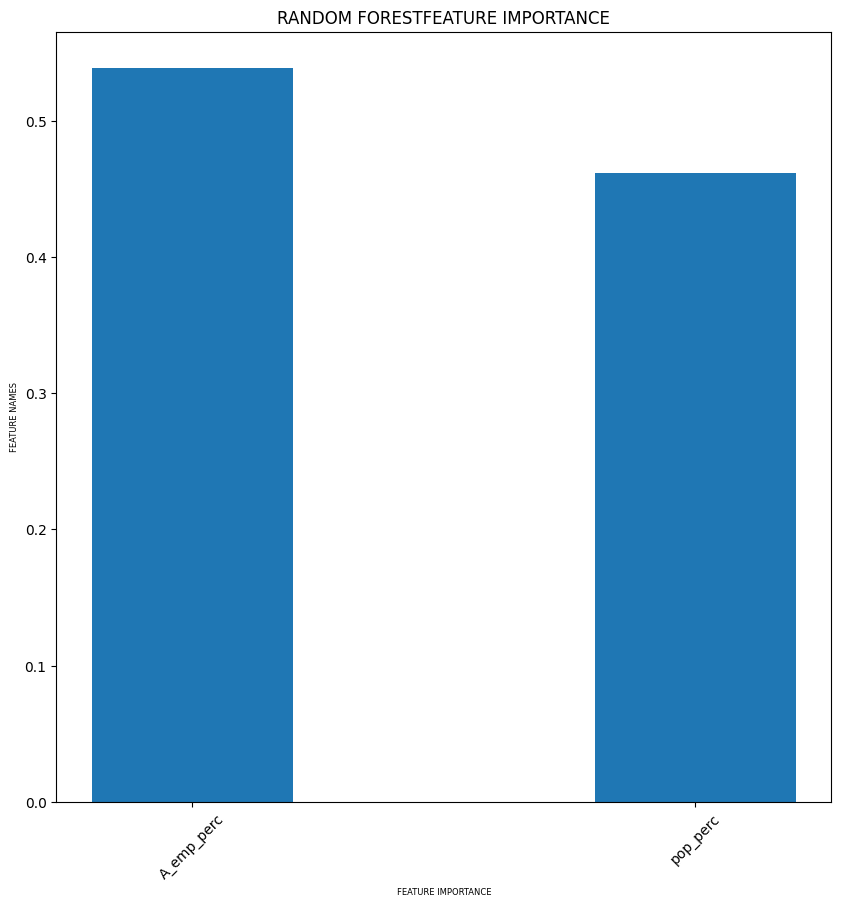

In [115]:
plot_feature_importance(reg1.feature_importances_, x_train_agr.columns,'RANDOM FOREST')

In [116]:
y_predict = reg1.predict(x_test_agr)
y_predict_train = reg1.predict(x_train_agr)
mean_squared_error(y_test_agr, y_predict, squared=False)

0.15291197464503758

#### Manufacturing

In [117]:
#### Manufacturing




ind.sort_values(by = ["NUTS_ID", "year"], inplace = True)
for col in ind.columns:
    if ind[col].dtypes != object:
        print(col)
        ind[col].fillna(ind.groupby(["NUTS_ID", "year"])[col].transform('median'))
ind.dropna(axis=0,inplace= True)
ind.reset_index(drop = True, inplace = True)
train_ind = ind.loc[ind["year"]<=2018].copy()
test_ind = ind.loc[ind["year"]>2018].copy()

x_train = train_ind.copy()
x_train.drop(columns = ["NUTS_ID", 'C_Gva_perc', 'year'], axis = 1, inplace = True)
x_test = test_ind.copy()


x_test_final = x_test.copy()

x_test.drop(columns = ["NUTS_ID", 'C_Gva_perc', 'year'], axis = 1, inplace = True)




y_train = train_ind['C_Gva_perc']
y_test = test_ind['C_Gva_perc']






reg = RandomForestRegressor(min_samples_leaf = 10)

reg.fit(x_train, y_train)

year
G-J_Gva_perc
Gva_Energ_perc
A_Gva_perc
pop_perc
C_emp_perc
C_Gva_perc


RandomForestRegressor(min_samples_leaf=10)

In [118]:
reg.score(x_test, y_test)

0.13888458915084778

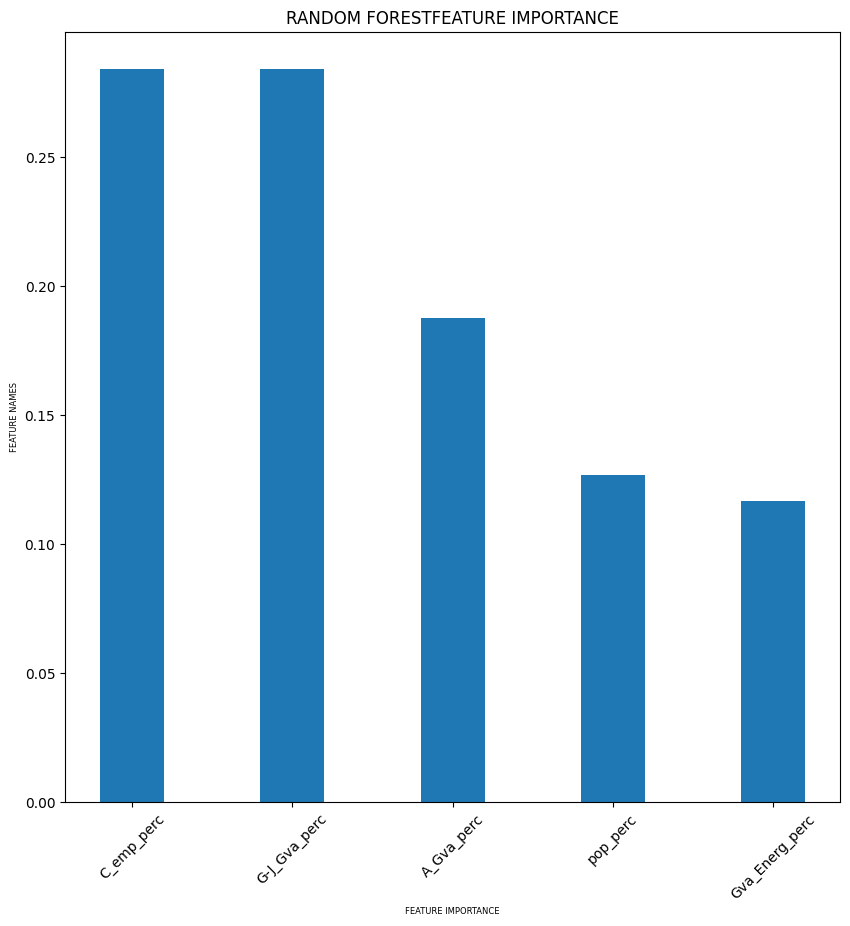

In [119]:
plot_feature_importance(reg.feature_importances_, x_train.columns,'RANDOM FOREST')

#### PREDICTING MODEL USING THE CLIMATE

##### IMPORTANTE: the direct prediction is a growth rate. There is a function to return a dataframe with the GVA prediction

In [120]:
# x_test_final is the copy of the test dataset before transformations and column removal. NUTS_ID should be in its original form (not dummy)
# segment should be 'C' if manufacturing or 'A' if agriculture
# model is the fitted regressor instance
# x_test is the x_test used in model.predict()


def return_gva(model, x_test, x_test_final, dfGva, segment):
    y_predict = model.predict(x_test)
    
    df_y_predict = pd.DataFrame(y_predict)
    df_y_predict.rename(columns = {0: "y_predict"}, inplace = True)

    x_test_return = pd.DataFrame(x_test)
    x_test_return.reset_index(drop = True, inplace = True)

    x_test_final.reset_index(drop = True, inplace = True)
    df = df_y_predict.merge(x_test_final, left_index = True, right_index = True)


    
    df = df.merge(dfGva, on = ["NUTS_ID", "year"]  , how = 'inner')

    df["Final_Prediction"] = df[segment+'_Gva_lag']*df['y_predict']+df[segment+'_Gva_lag']


    df = df[["NUTS_ID", 'Final_Prediction',"year", segment+'_Gva']]
    return df

#### Applying the function to get the value of the predictions 

In [129]:
#Manufacturing

man = return_gva(reg, x_test, x_test_final, dfGva, "C")
#man.to_csv("datafolder/ForComparsion_ONLY_Econ_man.csv")

In [ ]:
man

In [130]:
#Agriculture
agr = return_gva(reg1, x_test_agr, x_test_agr_final, dfGva, "A")
#agr.to_csv("datafolder/ForComparison_ONLY_Econ_agr.csv")

In [ ]:
agr